# Projet 4 : Segmentez des clients d'un site e-commerce
# Modélisation

## 1. Importation des données

### 1.1. Chargement des librairies

In [1]:
# Manipulation des données
import numpy as np
import pandas as pd

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

sns.set_style("whitegrid") # style choisi pour les graphes

# Outils de sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

# Modèles de sklearn
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Visualisation de dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Aide à la visualisation pour les modèles de clustering
from yellowbrick.cluster import KElbowVisualizer

# Utilisation du module nb_black pour formater le code
%load_ext nb_black

<IPython.core.display.Javascript object>

### 1.2. Chargement des données

In [2]:
data_all = pd.read_csv("data_all_for_clust.csv", index_col=0)
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94720 entries, 0 to 94719
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  94720 non-null  object 
 1   nb_cmd              94720 non-null  int64  
 2   montant_dep         94720 non-null  float64
 3   nb_prod             94720 non-null  int64  
 4   note_moy            94720 non-null  float64
 5   nb_jours_last_cmd   94720 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 5.1+ MB


<IPython.core.display.Javascript object>

In [3]:
data_all.describe()

nb_cmd   montant_dep       nb_prod      note_moy  \
count  94720.000000  94720.000000  94720.000000  94720.000000   
mean       1.033742    165.748545      1.179318      4.102190   
std        0.210529    227.106060      0.616014      1.327064   
min        1.000000      9.590000      1.000000      1.000000   
25%        1.000000     63.100000      1.000000      4.000000   
50%        1.000000    107.850000      1.000000      5.000000   
75%        1.000000    182.910000      1.000000      5.000000   
max       16.000000  13664.080000     24.000000      5.000000   

       nb_jours_last_cmd  
count       94720.000000  
mean          243.081803  
std           153.162612  
min             0.000000  
25%           118.845509  
50%           223.665006  
75%           352.406001  
max           728.494190

<IPython.core.display.Javascript object>

La présence d'outliers (plausibles) indique que l'on normalisera les données avec un RobustScaler qui réduit leur influence.

In [4]:
# Pourcentage de cliens ayant fait plus de 1 commande
data_all["nb_cmd"].loc[data_all["nb_cmd"] > 1].count() / len(data_all)

0.030289273648648647

<IPython.core.display.Javascript object>

In [5]:
# Pourcentage de cliens ayant commandé plus de 1 produit
data_all["nb_prod"].loc[data_all["nb_prod"] > 1].count() / len(data_all)

0.12380701013513513

<IPython.core.display.Javascript object>

In [6]:
# On met le customer_unique_id en index
df1_all = data_all.set_index("customer_unique_id")

<IPython.core.display.Javascript object>

# 2. Utilisation de l'ACP

On va regarder via l'analyse en composante principale (ACP ou PCA en anglais) si on peut faire ressortir 3 variables intéressantes.

### 2.1. Normalisation des données

In [7]:
X_all = df1_all.copy()
X_all.shape

(94720, 5)

<IPython.core.display.Javascript object>

In [8]:
# Normalisation des données avec RobustScaler
robust_scal_all = RobustScaler().fit(X_all)
X_scaled_all = robust_scal_all.transform(X_all)
X_scaled_all.shape

(94720, 5)

<IPython.core.display.Javascript object>

### 2.2. Entrainement des données

In [9]:
# Initialisation de la PCA
pca_all = PCA(random_state=0)
pca_all.fit(X_scaled_all)

# Affichage des pourcentages cumulés de variances expliquées
print(pca_all.explained_variance_ratio_.cumsum())

[0.58370181 0.86675789 0.93607038 0.99440905 1.        ]


<IPython.core.display.Javascript object>

Avec 3 variables, on explique presque 94% de la variance des données. Déjà avec 2 variables, on est à 86%.

### 2.3. Visualisation des composantes principales

In [10]:
def display_circles(
    pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None
):

    """ Fonction pour afficher dans des cercles de corrélation et
     selon les axes d'inertie les variables du jeu de données
        
    - Arguments :
        - pcs : données projetées sur PCA 
        - n_comp : nombre de composantes
        - axis_ranks : liste des axes par paire pour effectuer projection
        - labels : noms des variables du jeu de données
    
    - Affiche :
        - autant de graphes que de paires d'axes dans axis_ranks
            - projection sur composantes principales
            
    """

    # Pour chaque paire d'axes d'un plan factoriel
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(8, 8))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = (
                    min(pcs[d1, :]),
                    max(pcs[d1, :]),
                    min(pcs[d2, :]),
                    max(pcs[d2, :]),
                )

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(
                    np.zeros(pcs.shape[1]),
                    np.zeros(pcs.shape[1]),
                    pcs[d1, :],
                    pcs[d2, :],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="grey",
                )
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(
                    LineCollection(lines, axes=ax, alpha=0.1, color="black")
                )

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(
                            x,
                            y,
                            labels[i],
                            fontsize="14",
                            ha="center",
                            va="center",
                            rotation=label_rotation,
                            color="blue",
                            alpha=0.5,
                        )

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor="none", edgecolor="b")
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color="grey", ls="--")
            plt.plot([0, 0], [-1, 1], color="grey", ls="--")

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel(
                "F{} ({}%)".format(
                    d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)
                )
            )
            plt.ylabel(
                "F{} ({}%)".format(
                    d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)
                )
            )

            plt.title("Cercle des corrélations (F{} et F{})".format(d1 + 1, d2 + 1))
            plt.show(block=False)

<IPython.core.display.Javascript object>

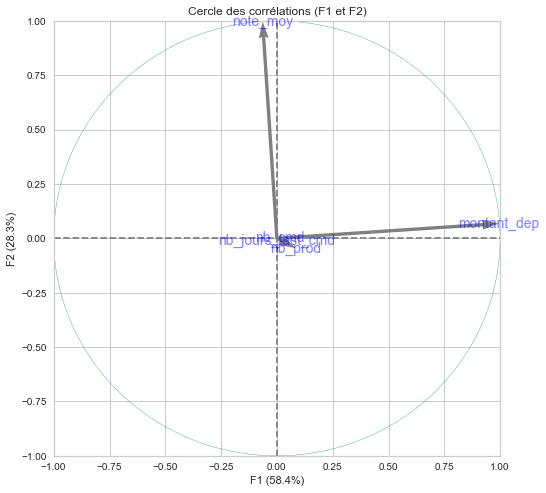

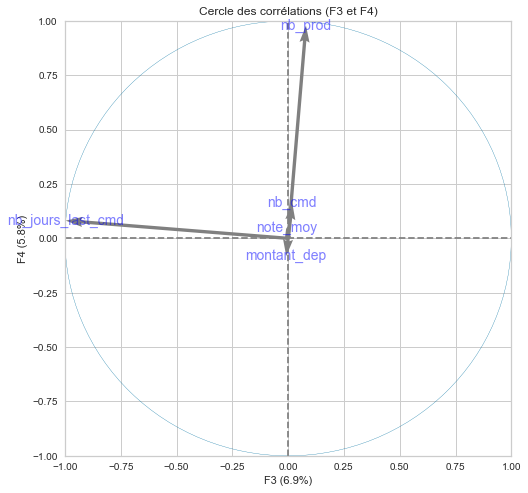

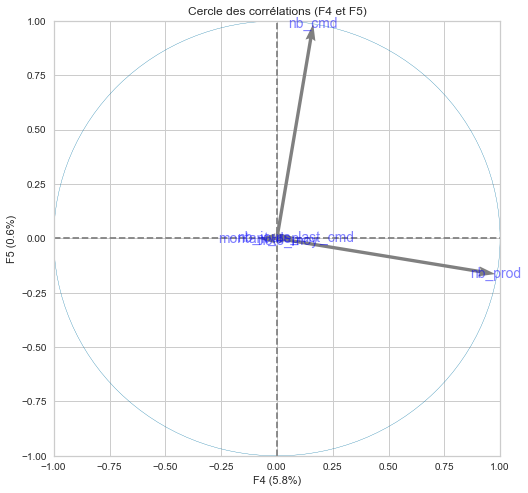

<IPython.core.display.Javascript object>

In [11]:
# Récupération des composantes de PCA
pcs_all = pca_all.components_

# Affichage des cercles de corrélation pour visualiser
# les composantes principales
display_circles(pcs_all, 5, pca_all, [(0, 1), (2, 3), (3, 4)], labels=X_all.columns)

Le montant dépensé a une forte contribution positive à la 1ère composante principale.

La note a une forte contribution positive à la 2ème composante principale.

Le nombre de jours depuis la dernière commande a une forte contribution négative à la 3ème composante principale.

On pourrait restreindre notre étude en ne conservant que les variables montant_dep, note_moy et nb_jours_last_cm.

### 2.4. Visualisation du jeu de données via les 3 premières composantes

In [12]:
def plot_3var(
    X_projected, name_proj, var1, var2, var3, labels=None, centroid=None,
):

    """ Fonction pour afficher la projection d'un jeu de données sur  
    3 variables
        
    - Arguments :
        - X_projected : données à utiliser pour la représentation (array) 
        - name_proj : type de projection (3 variables ou PCA) (string)
        - var1, var2, var3 : nom des variables (string)
        - labels : pour colorer les points selon les clusters
        - centroid : array contenant les coordonnées des centroids
    
    - Affiche :
        - 3 graphes 
            - projection sur variable1 et variable2
            - projection sur variable2 et variable3
            - projection sur variable1 et variable3
    """

    # Initialisation de la figure
    fig, ax = plt.subplots(figsize=(15, 22))

    # 1er graphe
    plt.subplot(421)
    sns.scatterplot(
        x=X_projected[:, 0], y=X_projected[:, 1], hue=labels, palette="tab20",
    )
    plt.xlabel("{}".format(var1), size=14)
    plt.ylabel("{}".format(var2), size=14)
    plt.title("Représentation du jeu de données via {}".format(name_proj), size=14)
    # Affichage des centroids
    if centroid is not None:
        for i in range(len(centroid)):
            plt.scatter(
                x=centroid[i, 0],
                y=centroid[i, 1],
                marker="X",
                linewidths=1,
                s=100,
                color=color_list[i],
            )

    # 2ème graphe
    plt.subplot(422)
    sns.scatterplot(
        x=X_projected[:, 1], y=X_projected[:, 2], hue=labels, palette="tab20",
    )
    plt.xlabel("{}".format(var2), size=14)
    plt.ylabel("{}".format(var3), size=14)
    # Affichage des centroids
    if centroid is not None:
        for i in range(len(centroid)):
            plt.scatter(
                x=centroid[i, 1],
                y=centroid[i, 2],
                marker="X",
                linewidths=1,
                s=100,
                color=color_list[i],
            )

    # 3ème graphe
    plt.subplot(423)
    sns.scatterplot(
        x=X_projected[:, 0], y=X_projected[:, 2], hue=labels, palette="tab20",
    )
    plt.xlabel("{}".format(var1), size=14)
    plt.ylabel("{}".format(var3), size=14)
    # Affichage des centroids
    if centroid is not None:
        for i in range(len(centroid)):
            plt.scatter(
                x=centroid[i, 0],
                y=centroid[i, 2],
                marker="X",
                linewidths=1,
                s=100,
                color=color_list[i],
            )

    plt.show()

<IPython.core.display.Javascript object>

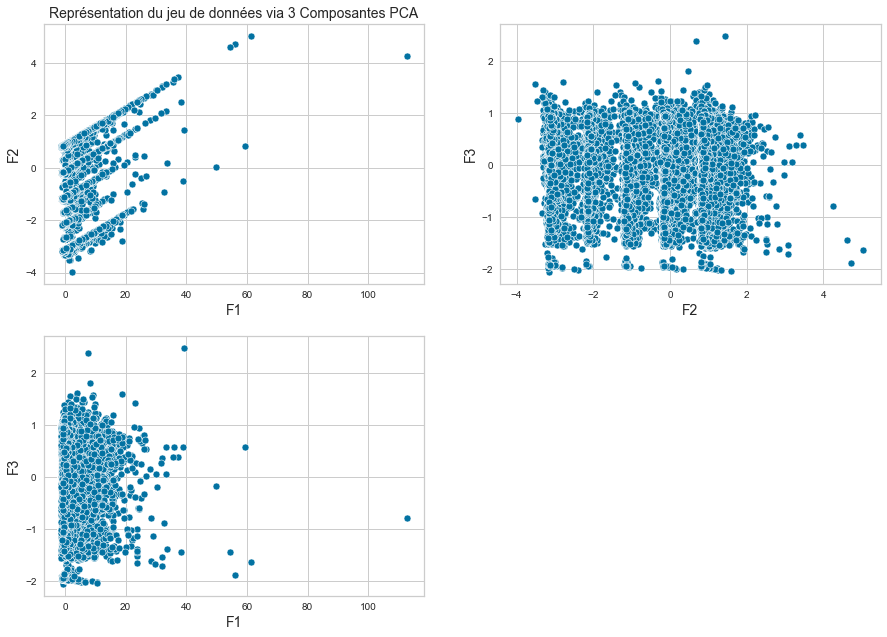

<IPython.core.display.Javascript object>

In [13]:
# Projection des données sur les 3 composantes principales
X_projected_all = pca_all.transform(X_scaled_all)
plot_3var(X_projected_all, "3 Composantes PCA", "F1", "F2", "F3")

<IPython.core.display.Javascript object>


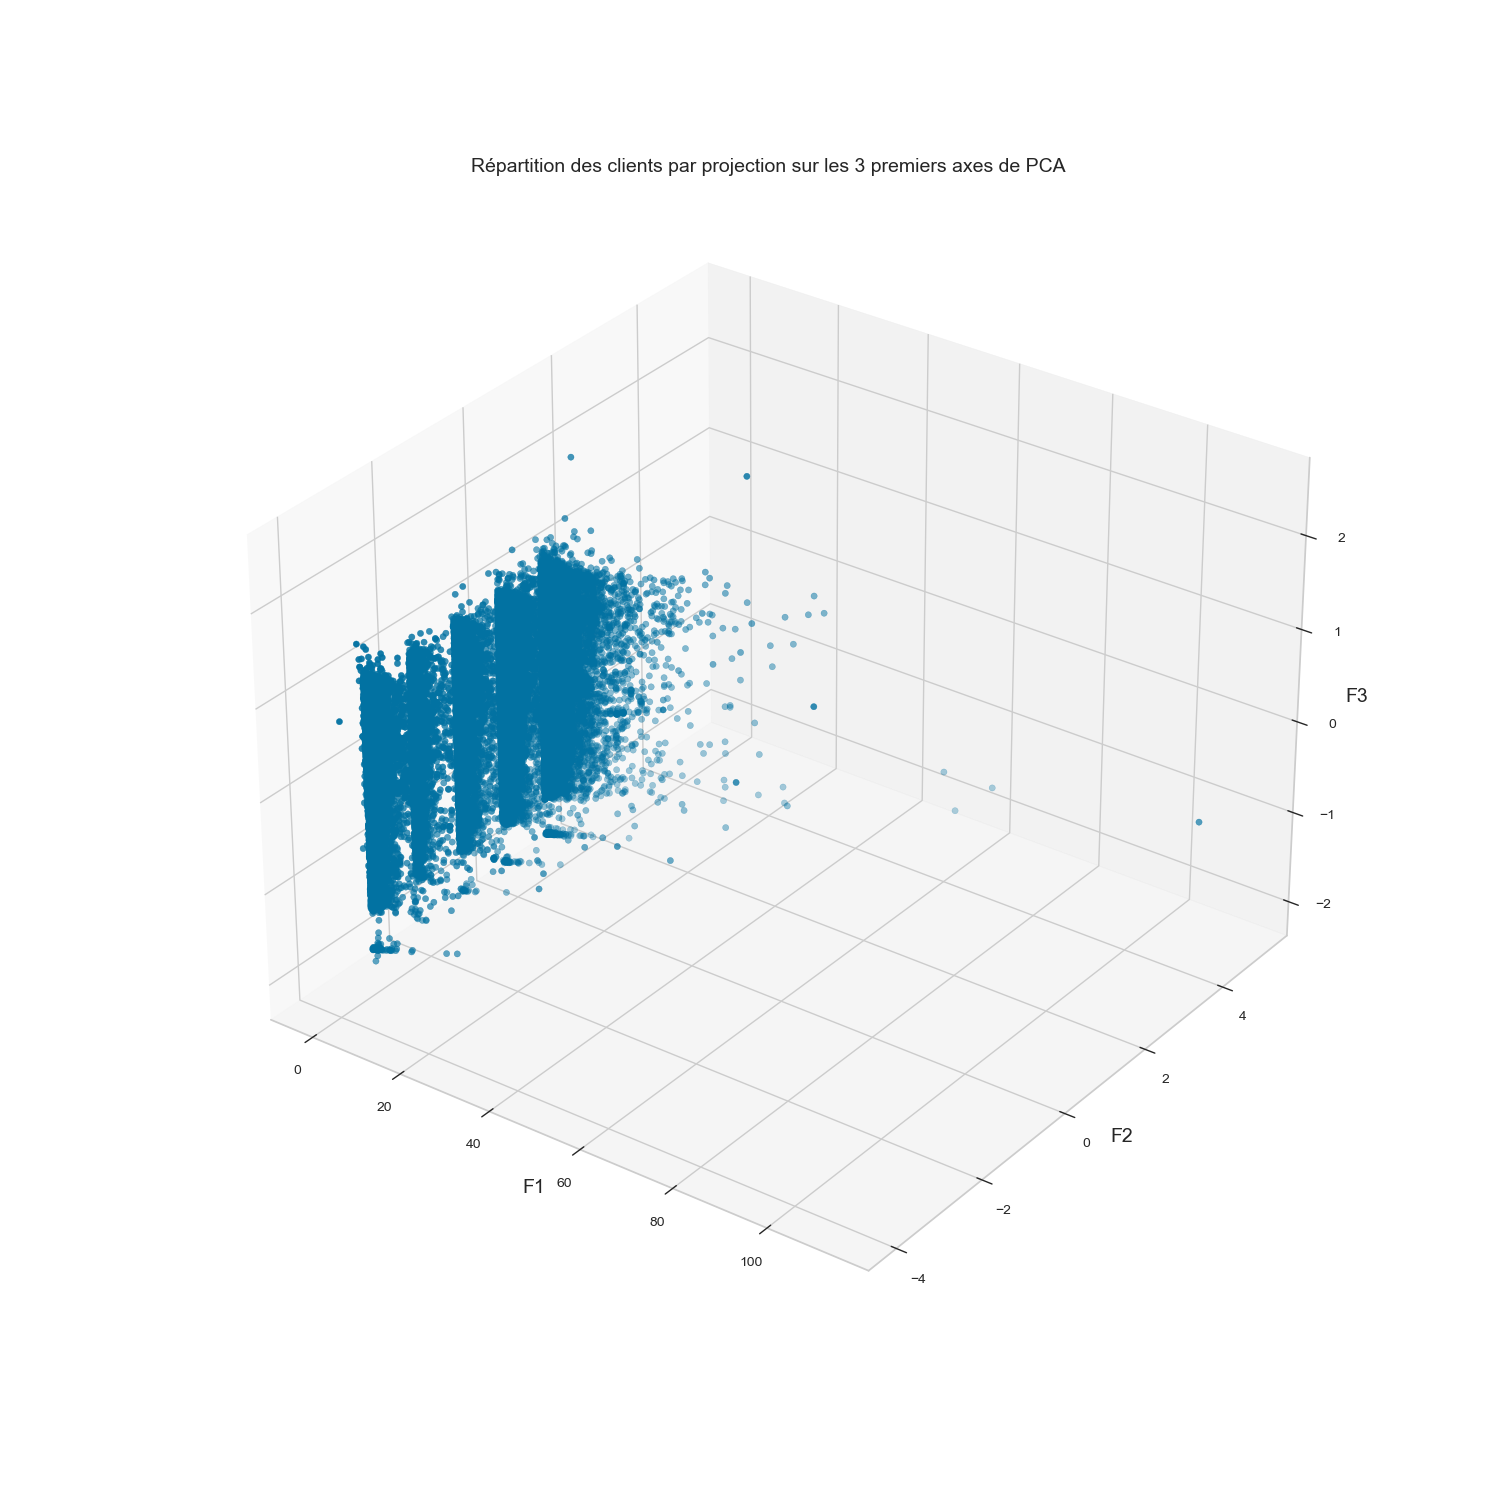

<IPython.core.display.Javascript object>

In [93]:
# Visualisation en 3D des données
%matplotlib notebook

plt.figure(figsize=(15, 15))
ax = plt.axes(projection="3d")
# Objet ax en 3D
ax.scatter(X_projected_all[:, 0], X_projected_all[:, 1], X_projected_all[:, 2])
ax.set_xlabel("F1", size=14)
ax.set_ylabel("F2", size=14)
ax.set_zlabel("F3", size=14)
plt.title(
    "Répartition des clients par projection sur les 3 premiers axes de PCA", size=14
)

plt.show()

On devine des groupes de clients selon la 2ème composante principale (quasiment équivalente à note_moy), mais ce n'est pas évident.

### 2.5. Echantillon réduit
On va utiliser cet échantillon réduit pour générer un dendrogramme.

In [14]:
# On sélectionne 15000 clients au hasard
df2_all = df1_all.sample(15000, random_state=0)
df2_all.shape

(15000, 5)

<IPython.core.display.Javascript object>

In [15]:
X = df2_all.copy()
X.shape

(15000, 5)

<IPython.core.display.Javascript object>

On va regarder sur PCA comment se projette cet échantillon réduit.

In [16]:
# Normalisation des données avec RobustScaler
robust_scal = RobustScaler().fit(X)
X_scaled = robust_scal.transform(X)

# Initialisation de la PCA
pca = PCA()
pca.fit(X_scaled)

# Affichage des % cumulés de variances expliquées
print(pca.explained_variance_ratio_.cumsum())

[0.54586018 0.857792   0.93615743 0.99432183 1.        ]


<IPython.core.display.Javascript object>

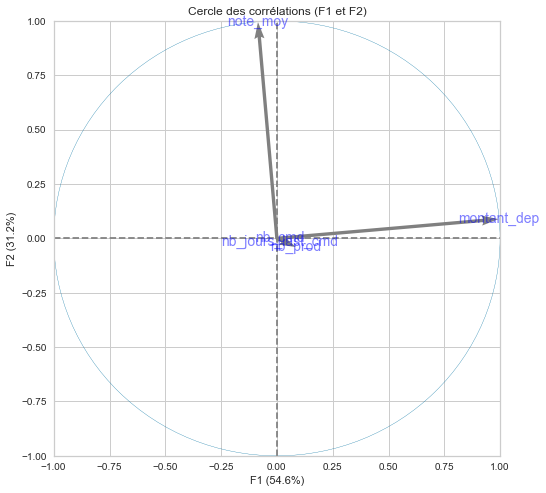

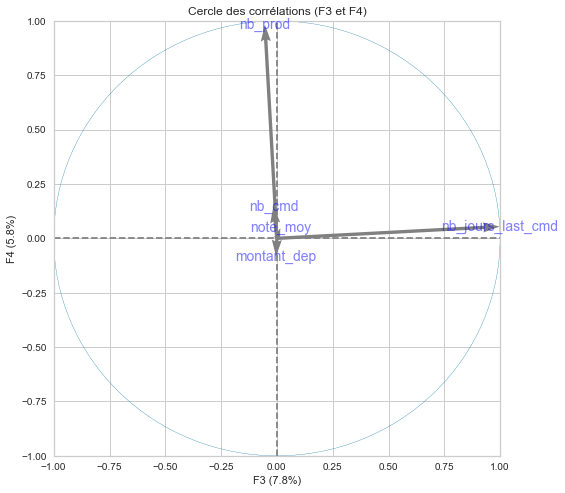

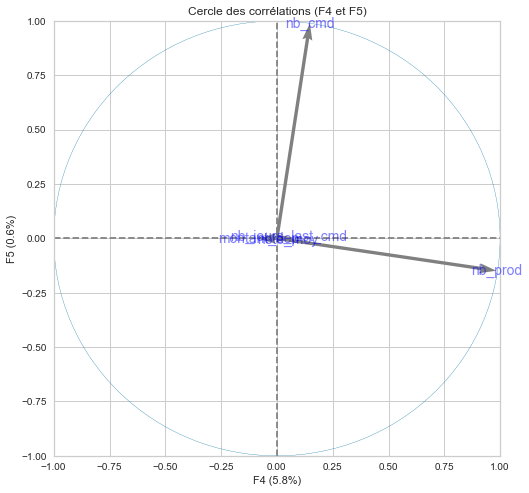

<IPython.core.display.Javascript object>

In [17]:
# Récupération des composantes PCA
pcs = pca.components_

# Affichage des cercles de corrélation pour visualiser
# les composantes principales
display_circles(pcs, 5, pca, [(0, 1), (2, 3), (3, 4)], labels=X.columns)

La 3ème composante est l'opposée de celle obtenue avec tout le dataset.

## 3. Clustering
### 3.1. Aperçu avec un dendrogramme sur échantillon réduit

Le dendrogramme (avec la méthode de Ward) va nous permettre d'avoir une estimation du nombre de clusters sur l'échantillon réduit.

Pour des raisons de performance, il n'a pas été possible de faire le dendrogramme sur l'ensemble des données. Cela nous permet d'écarter l'agglomerative clustering en modèle pour segmenter l'ensemble des données.

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [20.0, 20.0, 60.0, 60.0]],
 'dcoord': [[0.0, 24.228384978886453, 24.228384978886453, 0.0],
  [0.0, 50.15068769546565, 50.15068769546565, 0.0],
  [24.228384978886453, 71.7291123262238, 71.7291123262238, 50.15068769546565],
  [0.0, 53.29623112738897, 53.29623112738897, 0.0],
  [0.0, 139.42754085482338, 139.42754085482338, 0.0],
  [53.29623112738897,
   181.9176089628769,
   181.9176089628769,
   139.42754085482338],
  [71.7291123262238,
   210.08277075825723,
   210.08277075825723,
   181.9176089628769]],
 'ivl': ['(12)',
  '(112)',
  '(45)',
  '(8)',
  '(1291)',
  '(260)',
  '(1136)',
  '(12136)'],
 'leaves': [29950, 29960, 29953, 29956, 29978, 29981, 29992, 29995],
 'color_list': ['C1', 'C1', 'C1', 'C2', 'C3', 'C0', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C3', 'C3']}

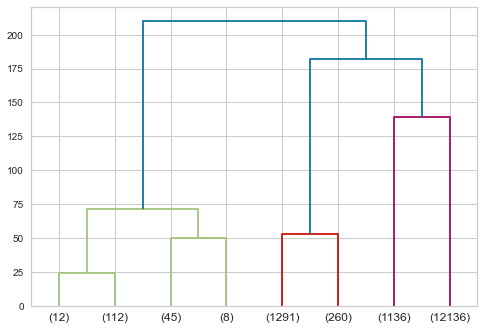

<IPython.core.display.Javascript object>

In [18]:
# Initialisation de la figure
plt.figure()

# Perform hierarchical/agglomerative clustering
dendrogram(
    linkage(X_scaled, method="ward"), truncate_mode="level", p=2,  # truncate mode
)
# No more than p levels of the dendrogram tree are displayed.
# A “level” includes all nodes with p merges from the final merge.

On s'attend à 3 ou 4 clusters sur échantillon réduit. On peut s'attendre à obtenir ces nombres sur l'ensemble des données.

### 3.2. Kmeans
#### a. Choix du nombre de clusters

In [19]:
def result_Kmeans(n_min, n_max, X):

    """ Fonction pour tester différentes valeurs de k pour le KMeans
   - pour chaque valeur de k 
       - fit le modèle
       - récupère les clusters label
       - récupère les coordonnées des centroids
       - récupère les valeurs pour les scores
           - inertie
           - coefficient de silhouette
           - indice de davies_bouldin
           - calinski_harabasz_score
           
   - Arguments :
       - n_min : nombre minimal de clusters
       - n_max : nombre maximal de clusters
       - X : data à fitter
   
   - Retourne :
       - un dataframe avec les résultats
   """

    # Création du dataframe
    results = pd.DataFrame(
        columns=[
            "model",
            "n_clusters",
            "labels",
            "centroids",
            "inertia",
            "silhouette_score",
            "davies_bouldin_score",
            "calinski_harabasz_score",
        ]
    )

    # On boucle sur le nombre de clusters
    for num_clusters in range(n_min, n_max):

        # initialisation aléatoire et unique
        cls = KMeans(n_clusters=num_clusters, random_state=1)
        # n_init = 10 par défaut
        # init = ''k-means++' par défaut

        # on fit le modèle
        cls.fit(X)

        # prédiction des étiquettes
        labels = cls.labels_

        # Récupération des résultats
        result = {
            "model": str(cls).replace(", random_state=1", ""),
            "n_clusters": num_clusters,
            "labels": labels,
            "centroids": cls.cluster_centers_,
            "inertia": cls.inertia_,
            "silhouette_score": silhouette_score(X, labels),
            "davies_bouldin_score": davies_bouldin_score(X, labels),
            "calinski_harabasz_score": calinski_harabasz_score(X, labels),
        }

        # On compile dans le dataframe
        results = results.append(result, ignore_index=True)

    return results

<IPython.core.display.Javascript object>

In [20]:
def plot_results(model, df):

    """ Fonction pour afficher les résultats d'un modèle
    - trace pour chaque valeur de n_clusters 
        - inertie
        - coefficient de silhouette
        - indice de davies_bouldin
        - calinski_harabasz_score
        
    - Arguments :
        - model : nom du modèle
        - df : dataframe contenant les scores des coefficients ci-dessus
    
    - Affiche :
        - 4 graphes représentant chacun un score
    """

    # Initialisation de la figure
    f, ax = plt.subplots(figsize=(15, 10))
    plt.suptitle("Résultats {} ".format(model))

    # 1er graphe : valeur de l'inertie
    plt.subplot(411)
    plt.plot(df["n_clusters"], df["inertia"], marker="o")
    plt.ylabel("inertie", size=12)

    # 2ème graphe : silhouette_score
    plt.subplot(412)
    plt.plot(df["n_clusters"], df["silhouette_score"], marker="o")
    plt.ylabel("coefficient de silhouette", size=12)

    # 3ème graphe : davies_bouldin_score
    plt.subplot(413)
    plt.plot(df["n_clusters"], df["davies_bouldin_score"], marker="o")
    plt.ylabel("Indice de Davies Bouldin", size=12)

    # 4ème graphe : calinski_harabasz_score
    plt.subplot(414)
    plt.plot(df["model"], df["calinski_harabasz_score"], marker="o")
    plt.xlabel("modèle", size=12)
    plt.ylabel("calinski_harabasz_score", size=12)
    plt.xticks(rotation=45, ha="right")

    plt.show()

<IPython.core.display.Javascript object>

##### Sur toutes les données avec les 5 variables

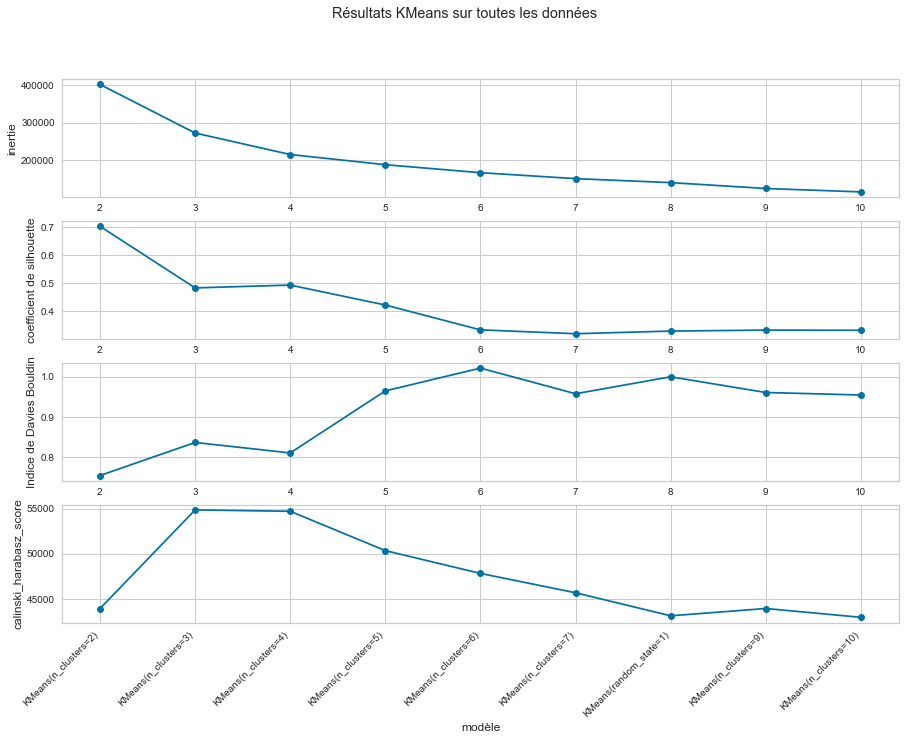

<IPython.core.display.Javascript object>

In [21]:
k_means_all = result_Kmeans(2, 11, X_scaled_all)
plot_results("KMeans sur toutes les données", k_means_all)

Pour choisir le nombre de clusters optimal, il faut :
- le silhouette_score le plus élevé
- le davies_bouldin_score le plus faible
- le calinski_harabasz_score le plus élevé

Pour n = 2 clusters, on a le le silhouette_score le plus élevé et le davies_bouldin_score le plus faible, mais 2 clusters ont peu d'intérêt.

Notre choix va donc se porter sur n = 4 clusters.

In [22]:
# Utilisation de la bibliothèque yellowbricks
liste_metric = ["distortion", "silhouette", "calinski_harabasz"]


def plot_elbow(n_min, n_max, X):

    """ Fonction pour afficher la “elbow” method pour aider au
    choix du nombre de clusters, selon les metrics 
        
    - Arguments :
       - n_min : nombre minimal de clusters
       - n_max : nombre maximal de clusters
       - X : data à fitter
    
    - Affiche :
        - 3 graphes représentant chacun un score en fonction du nombre
        de clusters
    """

    # Instantiate the clustering model
    model = KMeans(random_state=1)

    for met in liste_metric:

        # Instantiate visualizer
        visualizer = KElbowVisualizer(model, metric=met, k=(n_min, n_max))

        # Fit the data to the visualizer
        visualizer.fit(X)
        visualizer.poof()
        plt.show()

<IPython.core.display.Javascript object>

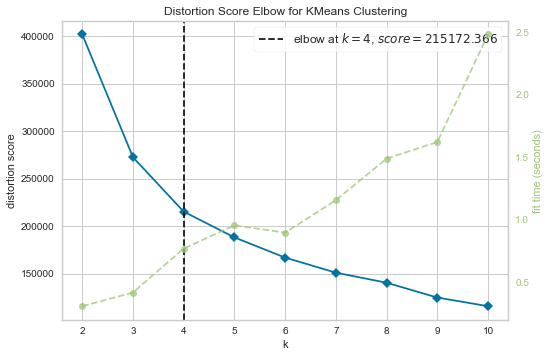

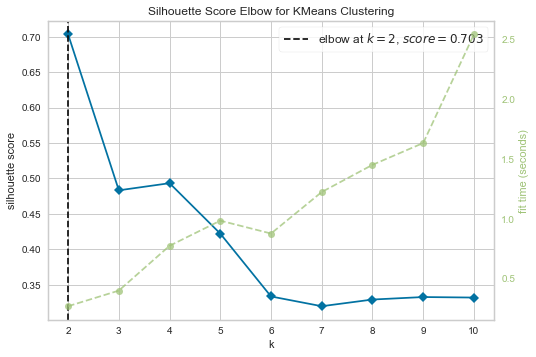

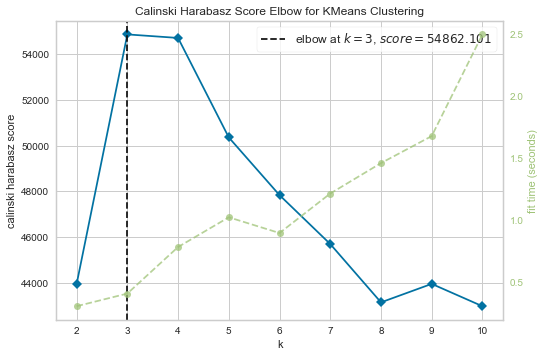

<IPython.core.display.Javascript object>

In [23]:
plot_elbow(2, 11, X_scaled_all)

Les 3 graphes n'indiquent pas la même valeur de k concernant l'elbow method. On va choisir 4 clusters.

In [24]:
def df_with_col_label(result, index, X):

    """ Fonction pour ajouter la colonne label dans le dataset d'origine
    selon le modèle choisi
        
    - Arguments :
        - result : dataset regroupand les résultats d'un modèle
        - index : index dans le dataset result correspondant au meilleur modèle
        - X : dataframe d'origine à qui il faut ajouter la colonne label
    
    - Retourne :
        - un dataset avec données d'origine + colonne label
    """

    # Récupération du meilleur modèle
    best_model = result.iloc[index]

    # Récupération des labels du meilleur modèle
    labels = best_model["labels"]

    # Copie du dataset d'origine
    X1 = X.copy()

    # Ajout de la colonne label
    X1["label"] = labels

    return X1

<IPython.core.display.Javascript object>

In [25]:
def perc_cluster_repartition(X_with_col_label):

    """ Fonction pour visualiser la répartition en pourcentage des individus
    selon les clusters (= labels)
        
    - Arguments :
        - X_with_col_label : dataframe d'origine avec la colonne label
    
    - Affiche :
        - un graphe représentant la distribution du nombre d'individus 
        par cluster, en pourcentage
        
    - Retourne : 
        - le nombre d'individus par cluster
    """

    # Visulisation sous forme de barplot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        x=X_with_col_label["label"].value_counts().index,
        y=X_with_col_label["label"].value_counts().values / len(X_with_col_label) * 100,
        palette="tab20",
    )
    plt.title("Distribution du nombre d'individus par cluster, en pourcentage", size=14)

    # ajout des étiquettes pour afficher valeurs de pourcentages
    for p in ax.patches:
        ax.annotate(
            format((p.get_height()), ".1f"),
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
            fontsize=12,
        )
    plt.show()

    return X_with_col_label["label"].value_counts()

<IPython.core.display.Javascript object>

In [26]:
# Ajout de la valeur du label dans le dataframe d'origine
# dans le cas de 4 clusters
best_kmeans_all4 = df_with_col_label(k_means_all, 2, X_all)

# Affichage du nombre de clients par label
best_kmeans_all4["label"].value_counts()

0    67411
3    19766
2     6718
1      825
Name: label, dtype: int64

<IPython.core.display.Javascript object>

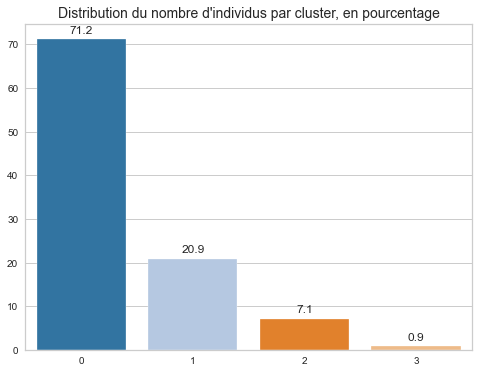

0    67411
1    19766
2     6718
3      825
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
# Changement des labels pour que le plus gros cluster en nombre
# de clients corresponde au label 0
best_kmeans_all4["label"].replace([0, 3, 2, 1], [0, 1, 2, 3], inplace=True)

# Répartition des clusters
perc_cluster_repartition(best_kmeans_all4)

On a des clusters déséquilibrés (71%, 21%, 7% et 1%)

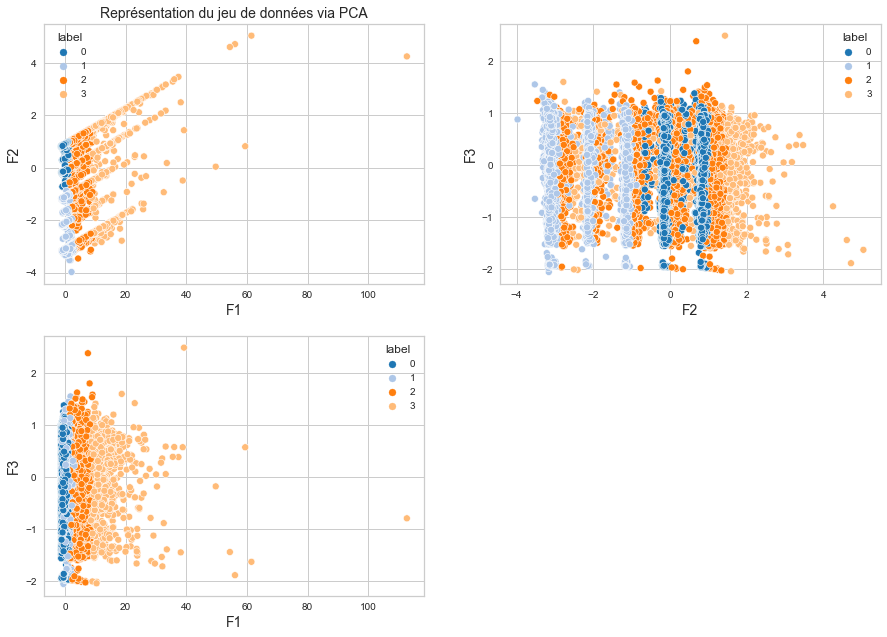

<IPython.core.display.Javascript object>

In [28]:
# Visualisation avec 4 clusters sur PCA
plot_3var(X_projected_all, "PCA", "F1", "F2", "F3", labels=best_kmeans_all4["label"])

Le cluster 0 est assez ramassé sur lui même, contrairement au cluster 3 qui est très dispersé

In [29]:
# Définition d'une nouvelle color map
newcmp = ListedColormap(["steelblue", "lightsteelblue", "darkorange", "sandybrown"])

<IPython.core.display.Javascript object>

In [30]:
def plot_3D(
    X_projected, name_proj, var1, var2, var3, labels=None, centroid=None,
):

    """ Fonction pour afficher la projection d'un jeu de données sur  
    3 variables en 3D
        
    - Arguments :
        - X_projected : données projectées sur les 3 variables
        à utiliser pour la représentation (array) 
        - name_proj : type de projection (3 variables ou PCA) (string)
        - var1, var2, var3 : nom des variables sur lesquels faire
        la projection (string)
        - labels : pour colorer les points selon les clusters
        - centroid : array contenant les coordonnées des centroids
    
    - Affiche :
        - 1 graphe 3D 
    """

    plt.figure(figsize=(15, 15))
    ax = plt.axes(projection="3d")
    plt.title(
        "Représentation du jeu de données en 3D via {}".format(name_proj), size=14
    )
    g = ax.scatter(
        X_projected[:, 0], X_projected[:, 1], X_projected[:, 2], c=labels, cmap=newcmp,
    )
    ax.set_xlabel(var1, size=14)
    ax.set_ylabel(var2, size=14)
    ax.set_zlabel(var3, size=14)
    ax.legend(*g.legend_elements(), title="cluster")
    
    # Affichage des centroids
    if centroid is not None:
        for i in range(len(centroid)):
            ax.scatter(
                centroid[i, 0],
                centroid[i, 1],
                centroid[i, 2],
                marker="X",
                linewidths=3,
                color=color_list[i],
                s=100,
                zorder=100,
            )
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


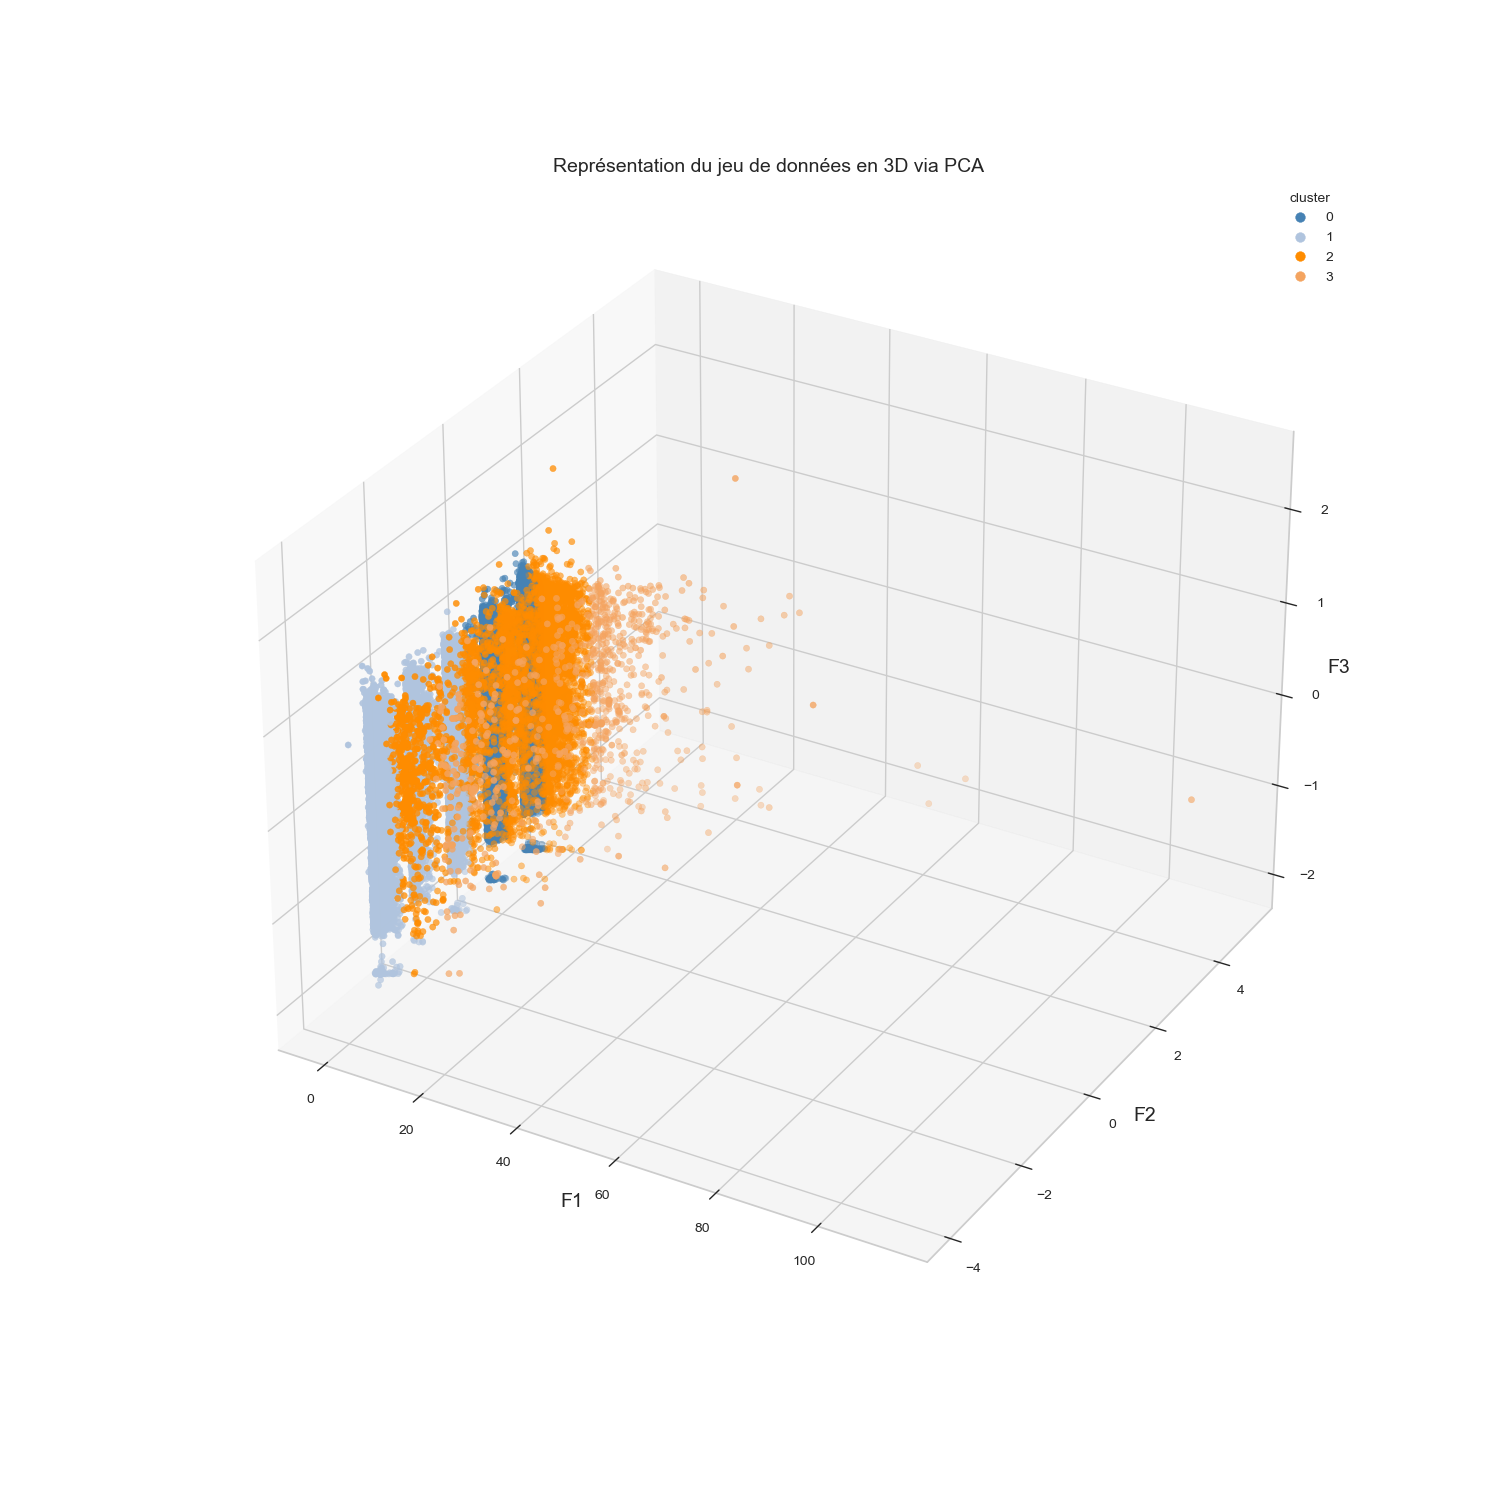

<IPython.core.display.Javascript object>

In [94]:
# Visualisation en 3D des données
plot_3D(
    X_projected_all, "PCA", "F1", "F2", "F3", labels=best_kmeans_all4["label"],
)

In [31]:
# Récupération des centroids
best_model = k_means_all.iloc[2]
centroids = best_model["centroids"]
centroids

array([[ 0.02476261,  0.06264305,  0.1122997 , -0.25333828,  0.07579158],
       [ 0.11138015, 14.16479775,  0.77845036, -1.14697337,  0.10031265],
       [ 0.14432224,  3.86367277,  0.63302616, -0.79759215,  0.07541042],
       [ 0.02347465,  0.19511642,  0.22837195, -3.11909339,  0.11008154]])

<IPython.core.display.Javascript object>

In [32]:
# Projection des centroids sur les 3 premières composantes
centroid_projected = pca_all.transform(centroids)

<IPython.core.display.Javascript object>

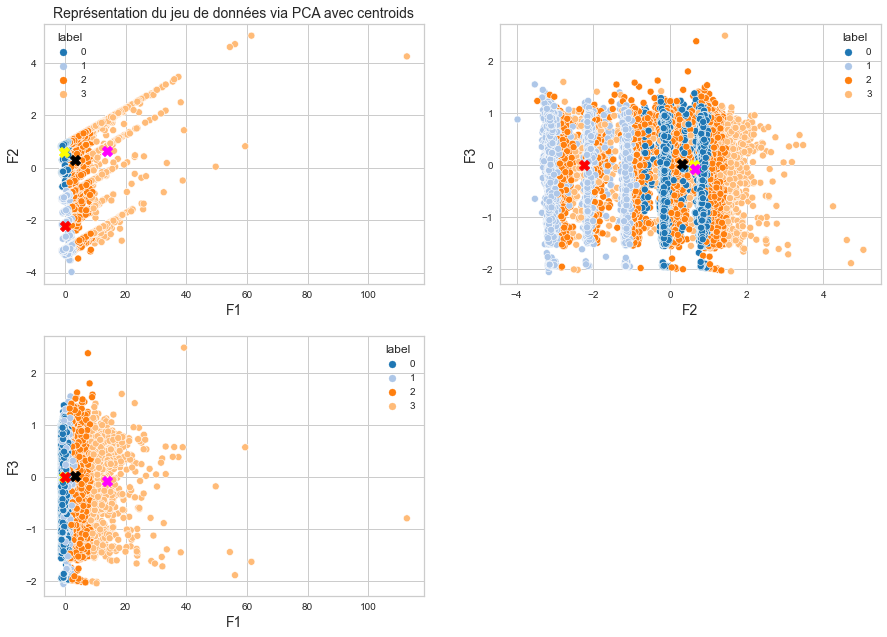

<IPython.core.display.Javascript object>

In [33]:
# Couleur centroids
# l'ordre de la liste ne correspond pas à l'ordre des clusters
# Assignation des couleurs aux clusters
# 0 = yellow ; 1 = red ; 2 = black ; 3 = magenta
color_list = ["yellow", "magenta", "black", "red"]

# Visualisation des points
plot_3var(
    X_projected_all,
    "PCA avec centroids",
    "F1",
    "F2",
    "F3",
    labels=best_kmeans_all4["label"],
    centroid=centroid_projected,
)

<IPython.core.display.Javascript object>


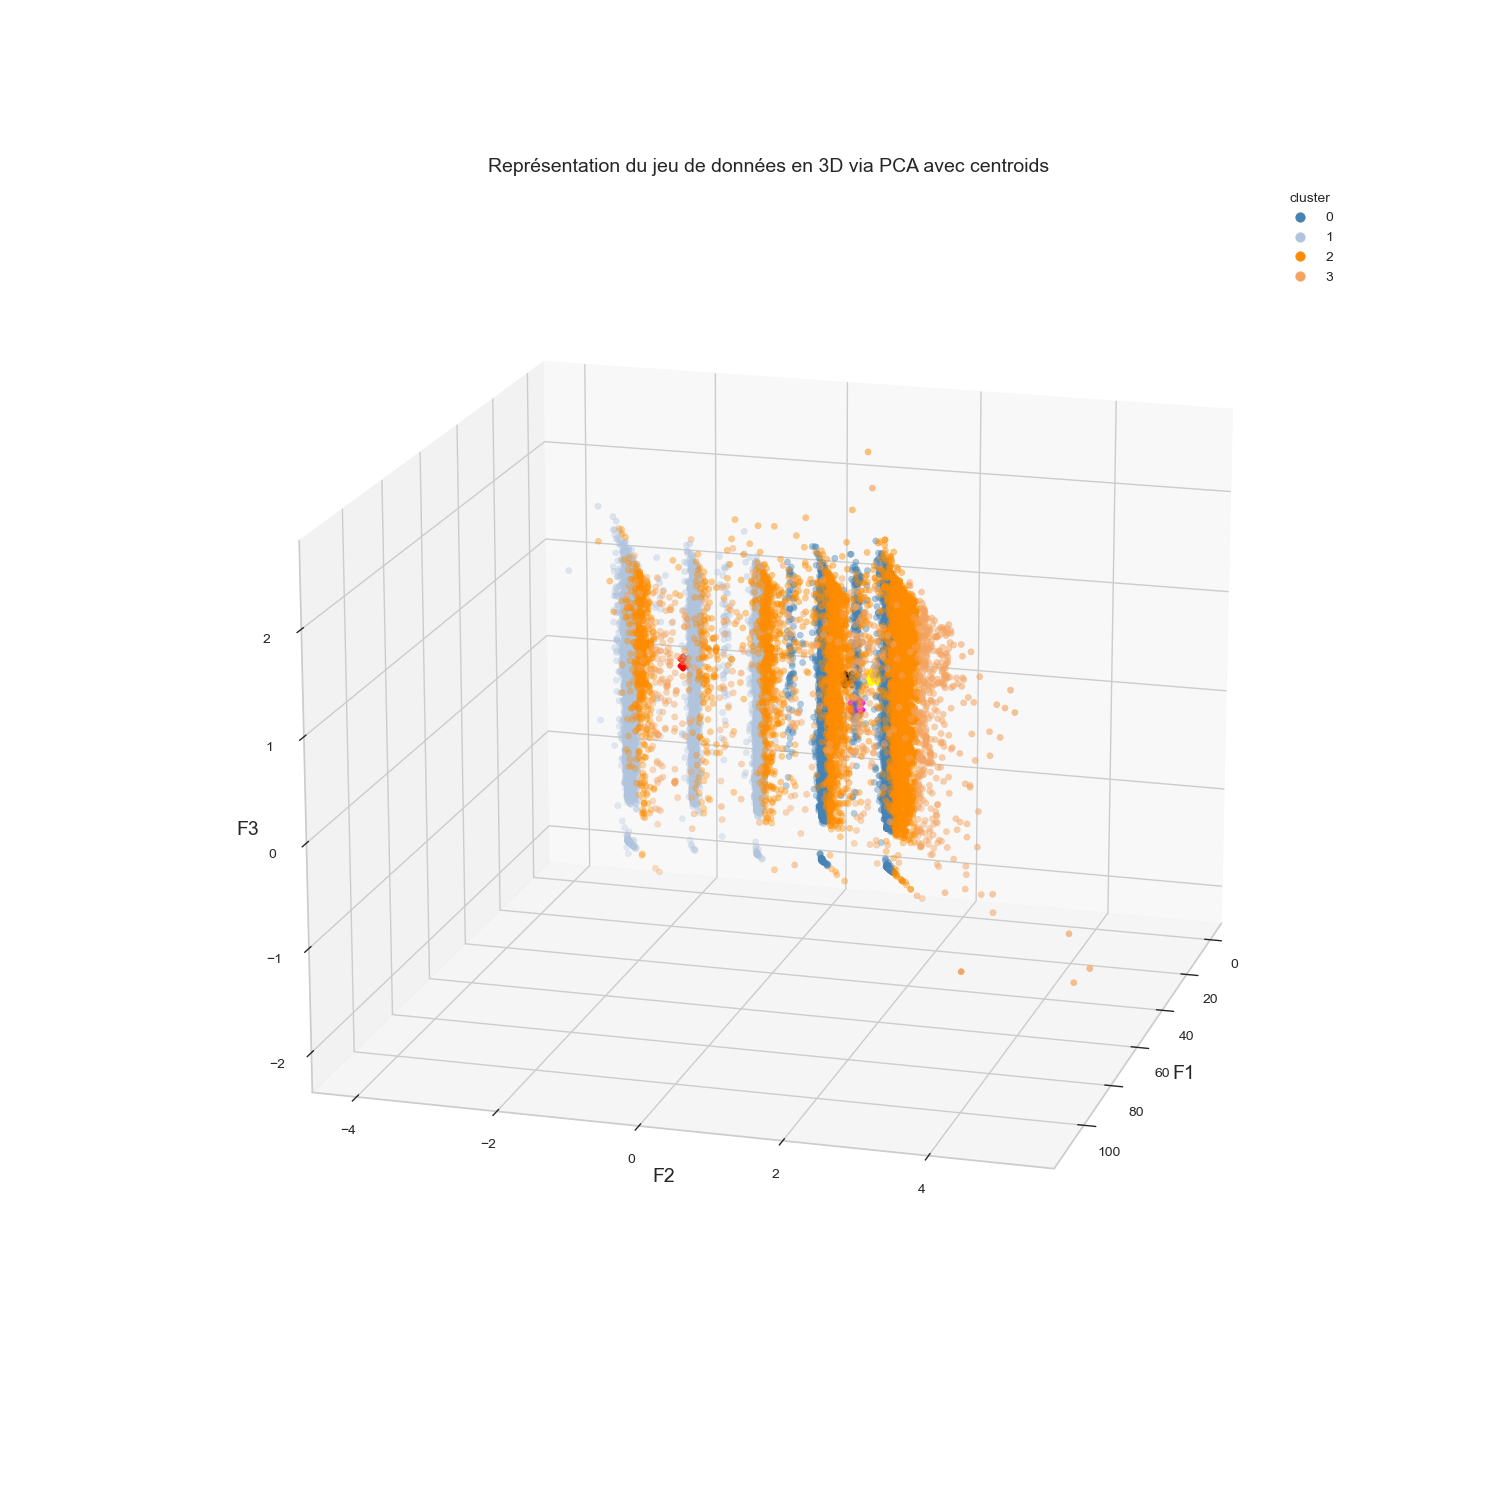

<IPython.core.display.Javascript object>

In [95]:
# Assignation des couleurs aux clusters
# 0 = yellow ; 1 = red ; 2 = black ; 3 = magenta
color_list = ["yellow", "magenta", "black", "red"]

# Visualisation en 3D
plot_3D(
    X_projected_all,
    "PCA avec centroids",
    "F1",
    "F2",
    "F3",
    labels=best_kmeans_all4["label"],
    centroid=centroid_projected,
)

##### Sur toutes les données avec les 5 variables projetées sur 3 axes PCA

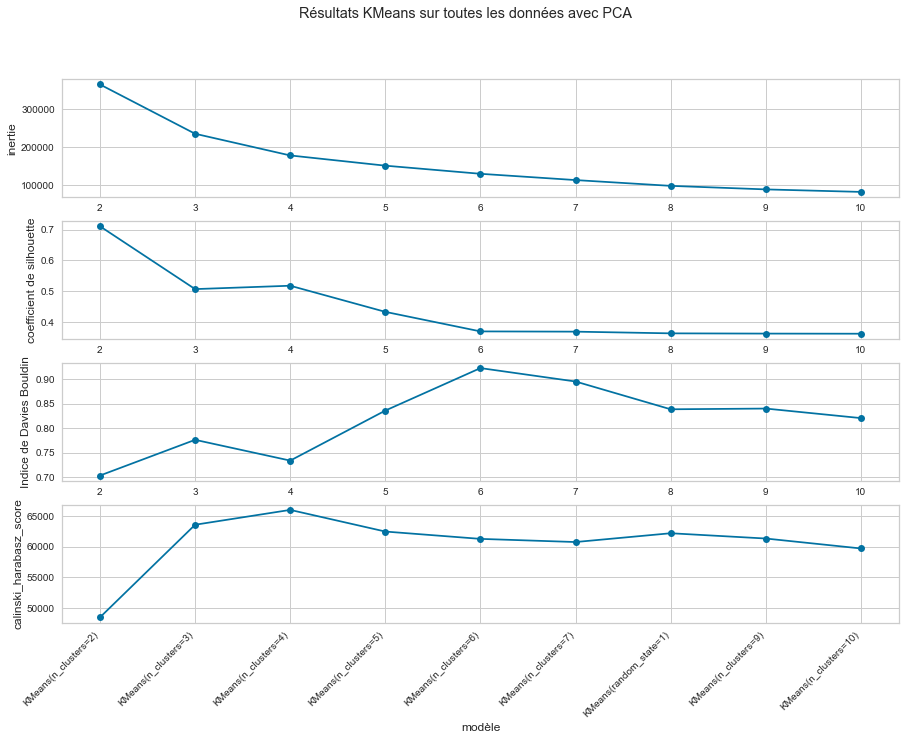

<IPython.core.display.Javascript object>

In [34]:
# Récupération des données sur les 3 premières composantes
X_pca_all = X_projected_all[:, :3]

# Entrainement des modèles
k_means_pca_all = result_Kmeans(2, 11, X_pca_all)

# Affichage des résultats
plot_results("KMeans sur toutes les données avec PCA", k_means_pca_all)

A part 2 clusters, les résultats semblent indiquer une meilleure segmentation sur 4 clusters.

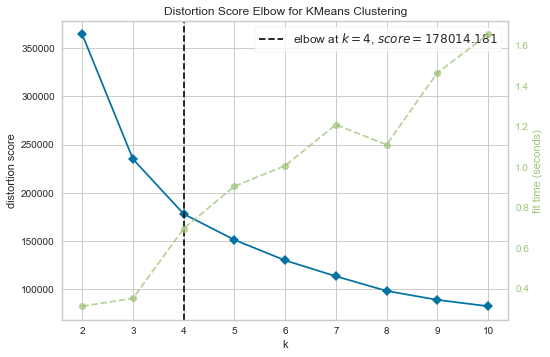

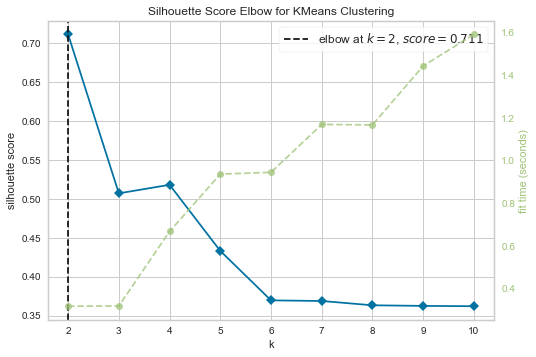

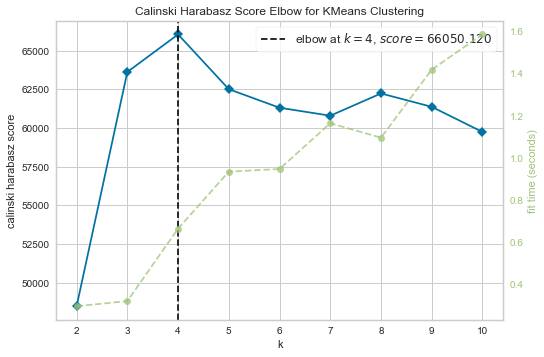

<IPython.core.display.Javascript object>

In [35]:
plot_elbow(2, 11, X_pca_all)

Par l'elbow method, on a 2 metrics qui suggèrent 4 clusters.

In [36]:
# Ajout de la valeur du label dans le dataframe d'origine
# dans le cas de 4 clusters
best_kmeans_pca_all4 = df_with_col_label(k_means_pca_all, 2, X_all)

# Affichage du nombre de clients par label
best_kmeans_pca_all4["label"].value_counts()

1    67448
0    19798
2     6647
3      827
Name: label, dtype: int64

<IPython.core.display.Javascript object>

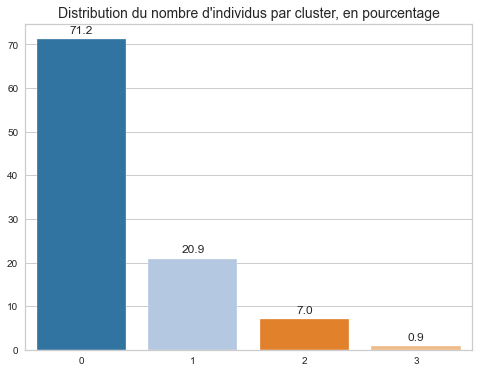

0    67448
1    19798
2     6647
3      827
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [37]:
# Changement des labels pour que le plus gros cluster en nombre
# de clients corresponde au label 0
best_kmeans_pca_all4["label"].replace([1, 0, 2, 3], [0, 1, 2, 3], inplace=True)

# Répartition des clusters
perc_cluster_repartition(best_kmeans_pca_all4)

On a des clusters déséquilibrés avec une répartition équivalente à la modélisation précédente.

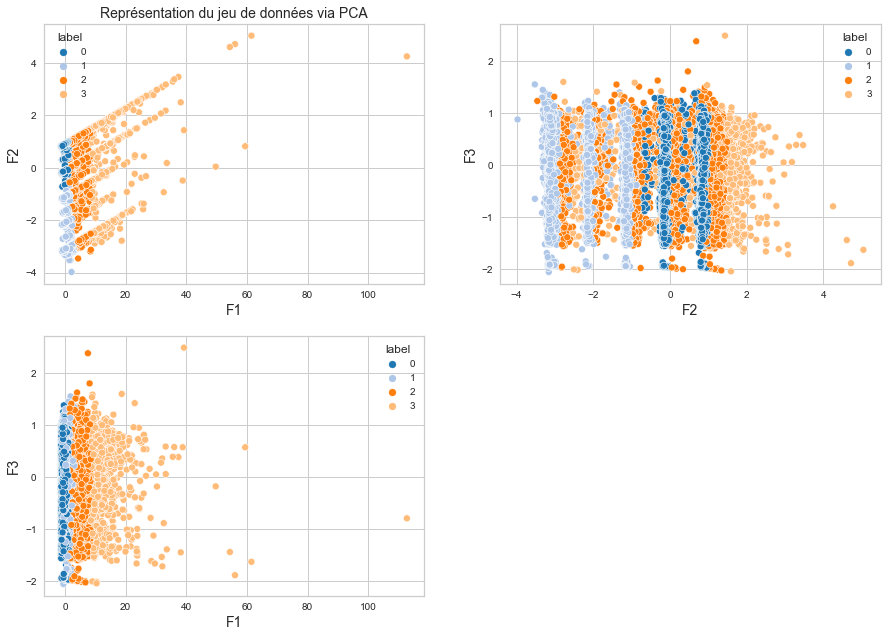

<IPython.core.display.Javascript object>

In [38]:
# Visualisation avec 4 clusters sur PCA
plot_3var(
    X_projected_all, "PCA", "F1", "F2", "F3", labels=best_kmeans_pca_all4["label"]
)

Mêmes remarques que dans la précédente modélisation

<IPython.core.display.Javascript object>


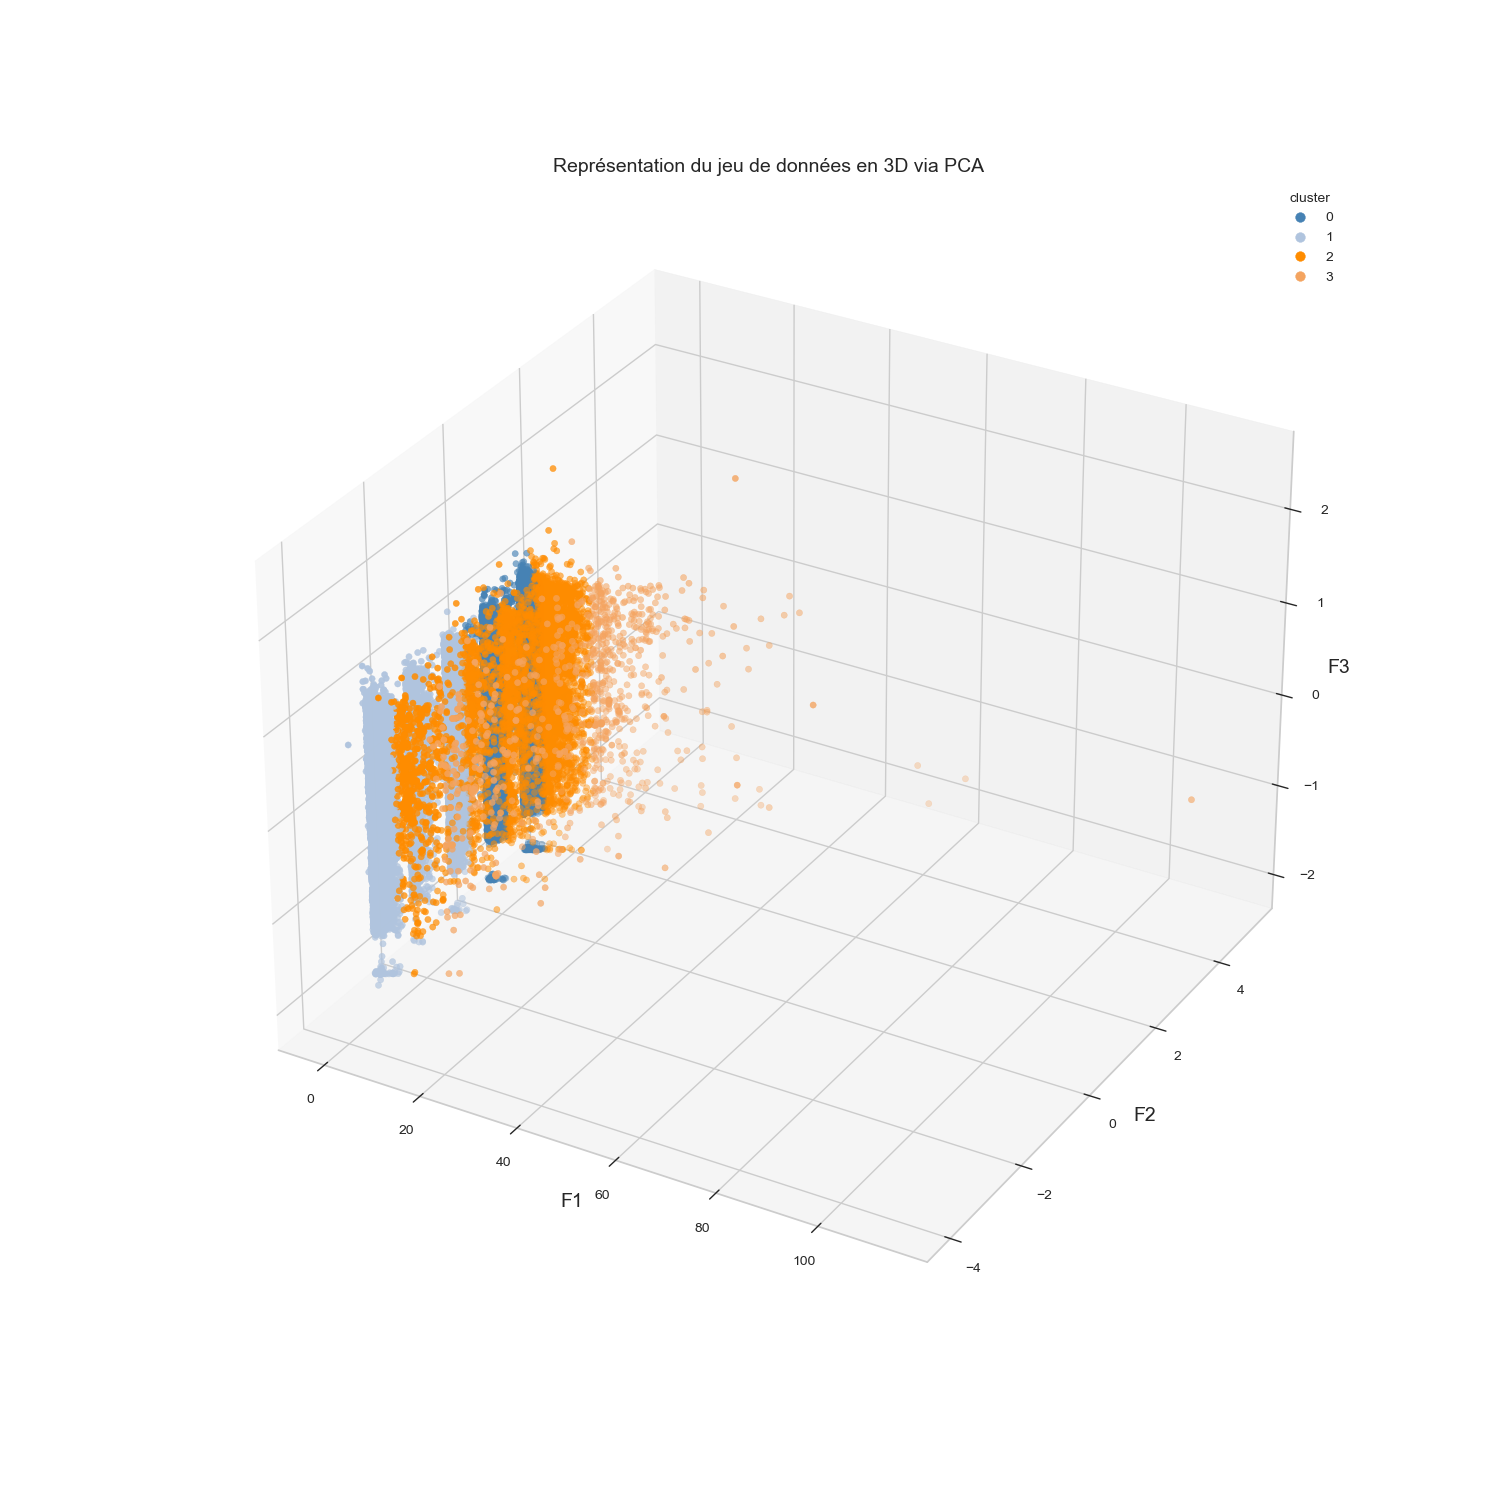

<IPython.core.display.Javascript object>

In [96]:
# Visualisation en 3D des données
plot_3D(X_projected_all, "PCA", "F1", "F2", "F3", labels=best_kmeans_pca_all4["label"])

In [39]:
# Récupération des centroids
best_model_pca = k_means_pca_all.iloc[2]
centroids_pca = best_model_pca["centroids"]

<IPython.core.display.Javascript object>

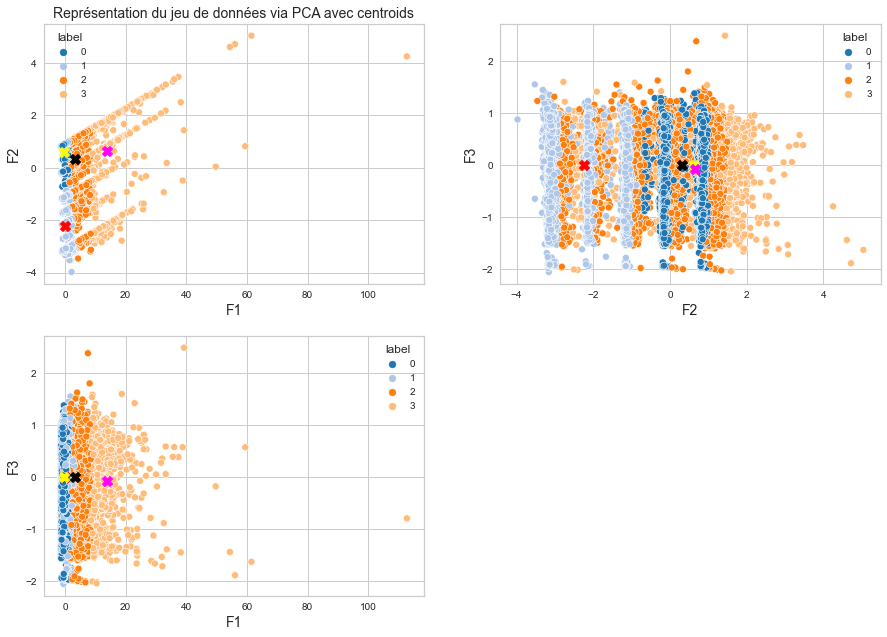

<IPython.core.display.Javascript object>

In [41]:
# Couleur centroids
# l'ordre de la liste ne correspond à l'ordre des clusters
# Assignation des couleurs aux clusters
# 0 = yellow ; 1 = red ; 2 = black ; 3 = magenta
color_list = ["red", "yellow", "black", "magenta"]

# Visualisation des points
plot_3var(
    X_projected_all,
    "PCA avec centroids",
    "F1",
    "F2",
    "F3",
    labels=best_kmeans_pca_all4["label"],
    centroid=centroids_pca,
)

<IPython.core.display.Javascript object>


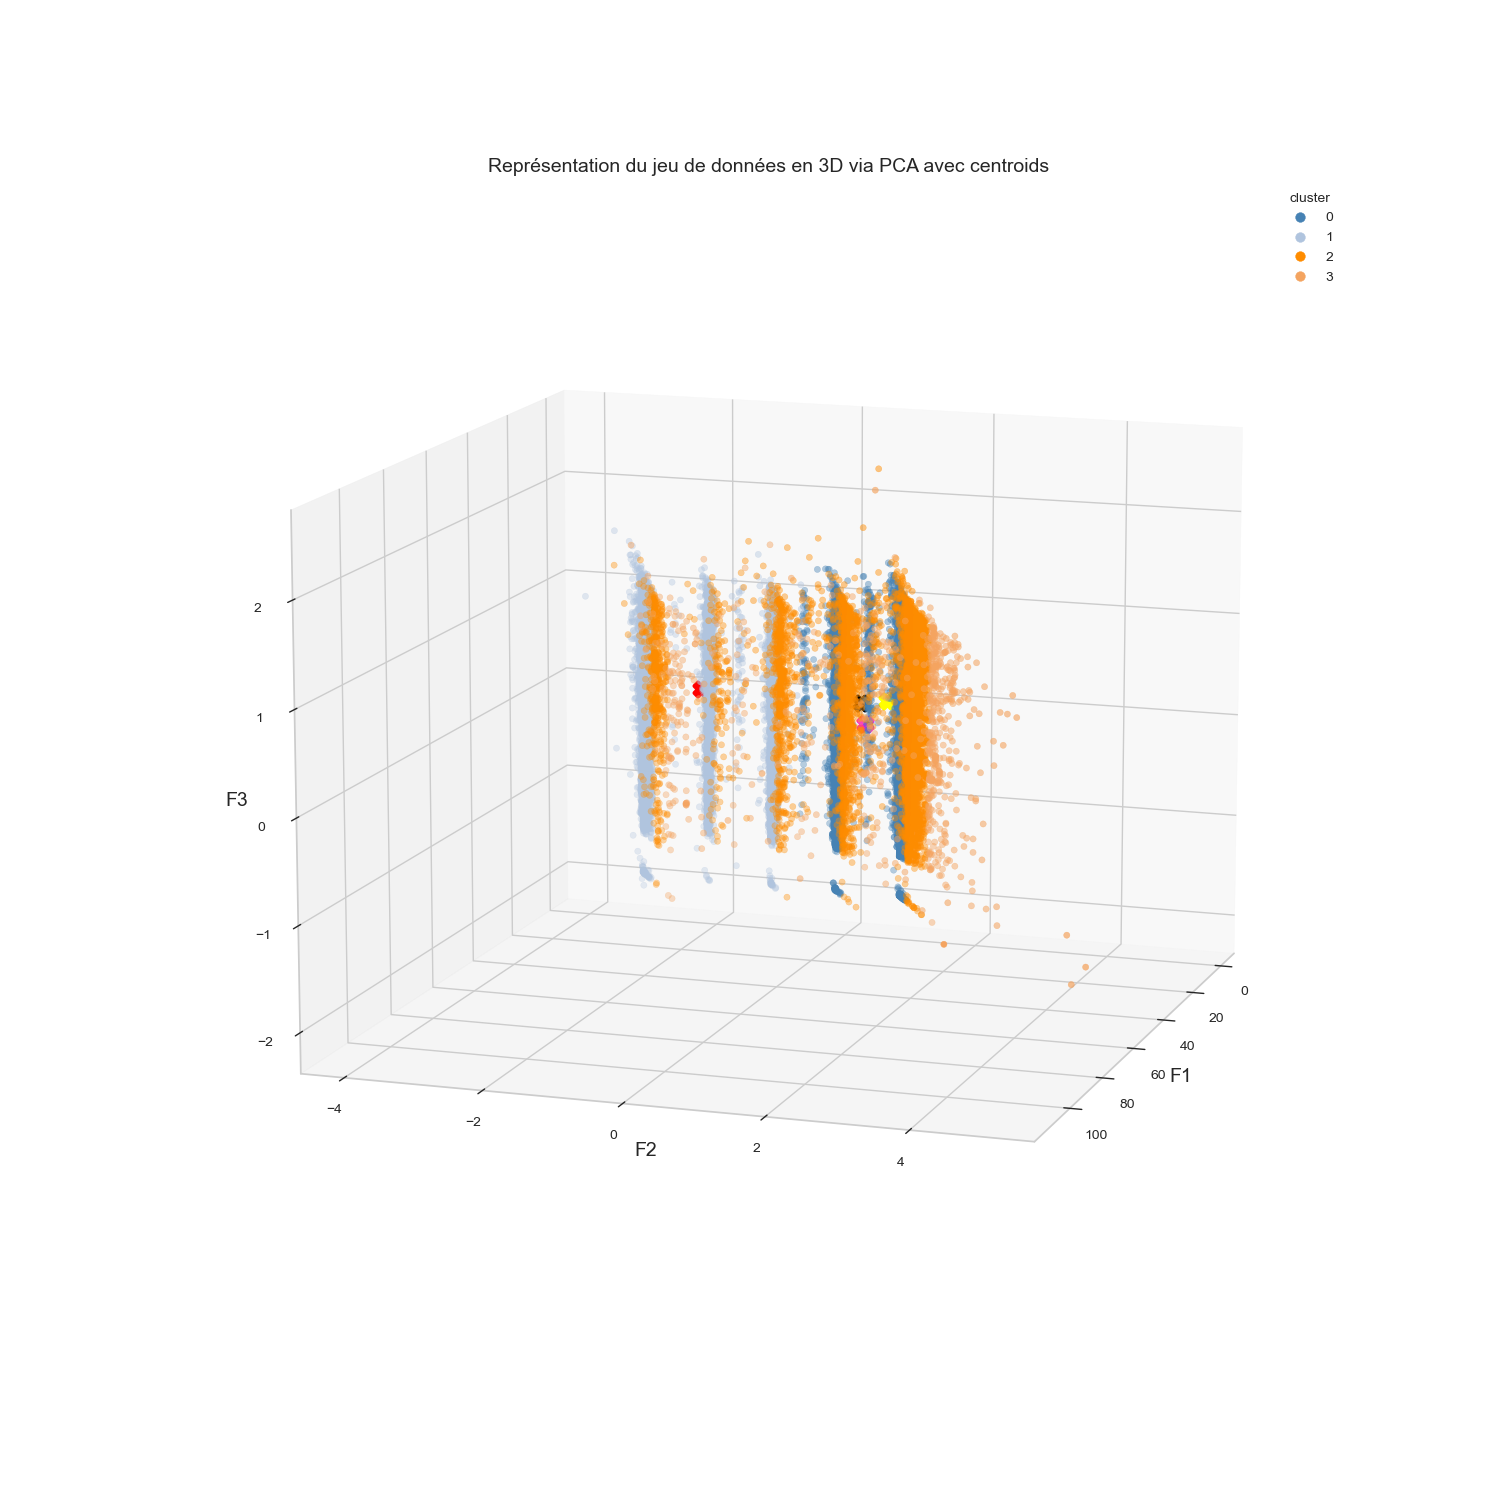

<IPython.core.display.Javascript object>

In [97]:
color_list = ["red", "yellow", "black", "magenta"]

# Visualisation des points
plot_3D(
    X_projected_all,
    "PCA avec centroids",
    "F1",
    "F2",
    "F3",
    labels=best_kmeans_pca_all4["label"],
    centroid=centroids_pca,
)

##### Sur toutes les données avec les 3 variables : montant_dep, note_moy et nb_jours_last_cmd
D'après la PCA, on a vu que les 3 composantes principales étaient "assimilables" à montant_dep, note_moy et nb_jours_last_cmd. 

On va donc faire les modélisations en entrainant uniquement sur ces 3 variables.

In [42]:
df_3var_all = df1_all.drop(["nb_cmd", "nb_prod"], axis=1)

# Normalisation des données avec RobustScaler
X_3var = df_3var_all.values
robust_scal_3var = RobustScaler().fit(X_3var)
X_scaled_3var = robust_scal_3var.transform(X_3var)

<IPython.core.display.Javascript object>

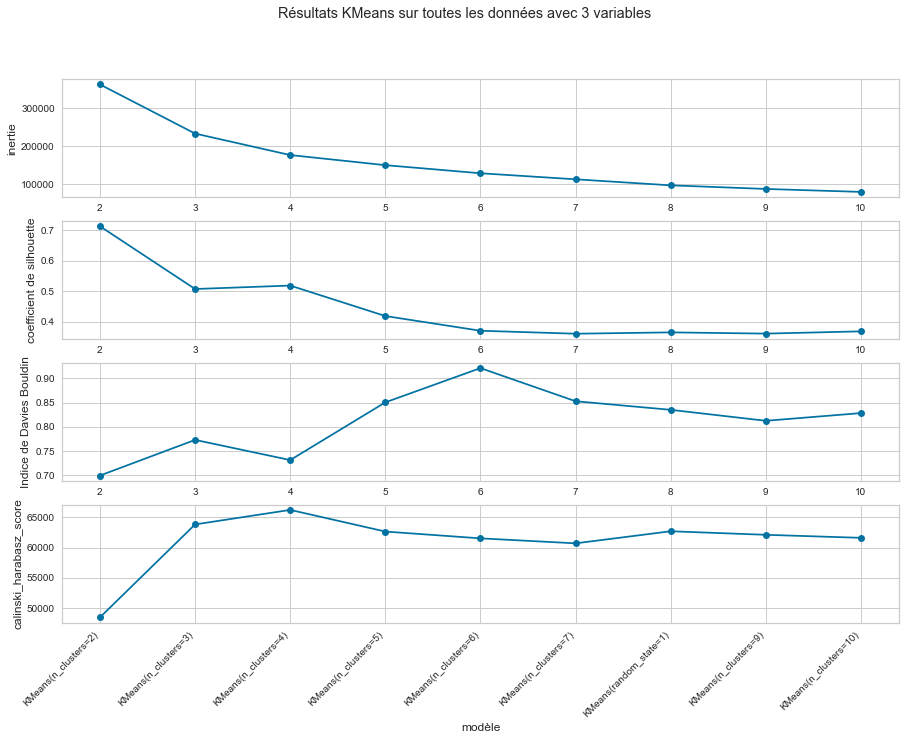

<IPython.core.display.Javascript object>

In [43]:
k_means_3var = result_Kmeans(2, 11, X_scaled_3var)
plot_results("KMeans sur toutes les données avec 3 variables", k_means_3var)

A part 2 clusters, les résultats semblent indiquer une meilleure segmentation sur 4 clusters.

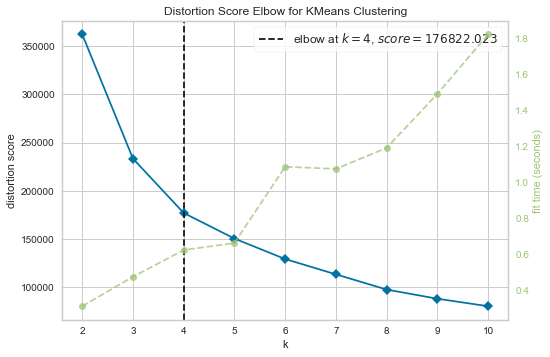

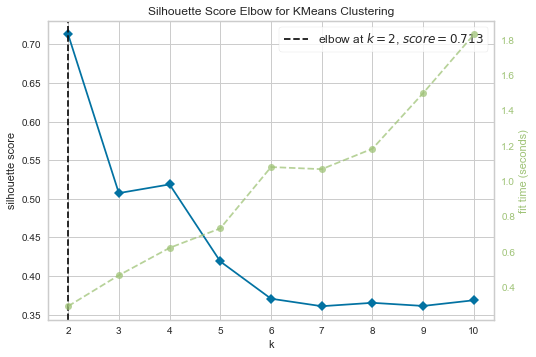

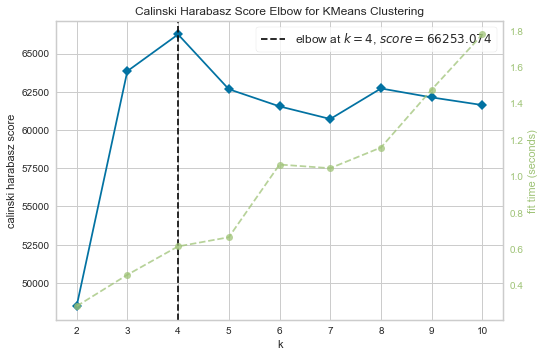

<IPython.core.display.Javascript object>

In [44]:
plot_elbow(2, 11, X_scaled_3var)

Par l'elbow method, on a 2 metrics qui suggèrent 4 clusters.

In [45]:
# Ajout de la valeur du label dans le dataframe d'origine
# dans le cas de 4 clusters
best_kmeans_3var4 = df_with_col_label(k_means_3var, 2, X_all)

# Affichage du nombre de clients par label
best_kmeans_3var4["label"].value_counts()

3    67590
0    19813
1     6496
2      821
Name: label, dtype: int64

<IPython.core.display.Javascript object>

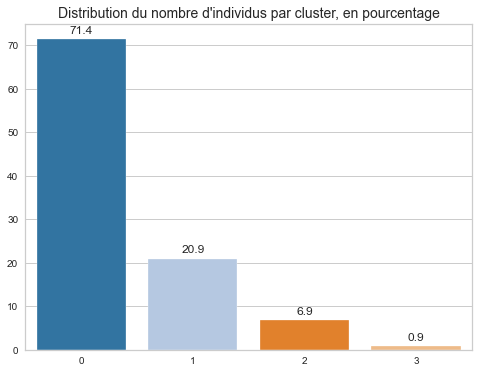

0    67590
1    19813
2     6496
3      821
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [46]:
# Changement des labels pour que le plus gros cluster en nombre
# de clients corresponde au label 0
best_kmeans_3var4["label"].replace([3, 0, 1, 2], [0, 1, 2, 3], inplace=True)

# Répartition des clusters
perc_cluster_repartition(best_kmeans_3var4)

On a à peu près la même répartition qu'avec les modèles précédents.

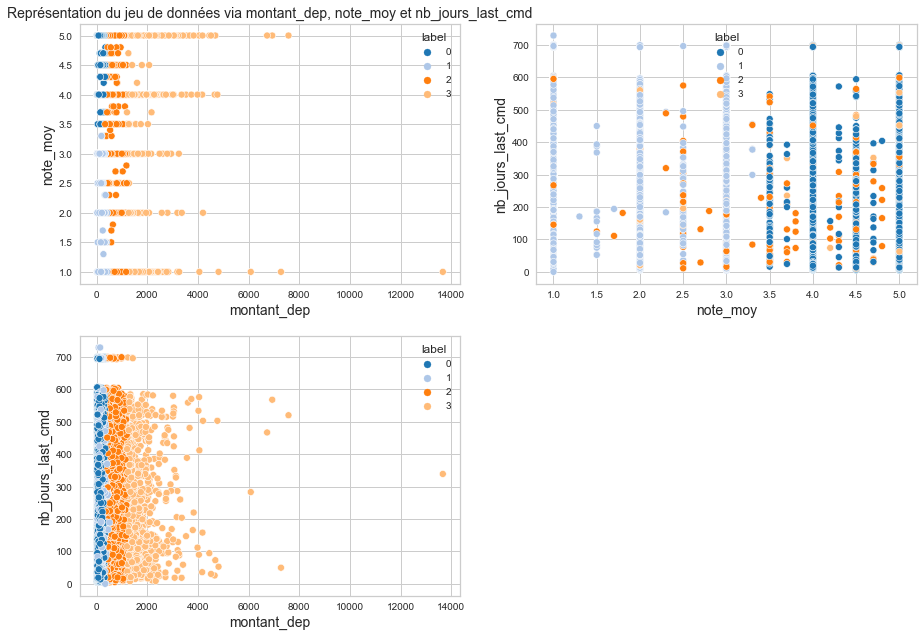

<IPython.core.display.Javascript object>

In [47]:
# Visualisation avec 4 clusters sur les 3 variables
plot_3var(
    X_3var,
    "montant_dep, note_moy et nb_jours_last_cmd",
    "montant_dep",
    "note_moy",
    "nb_jours_last_cmd",
    labels=best_kmeans_3var4["label"],
)

<IPython.core.display.Javascript object>


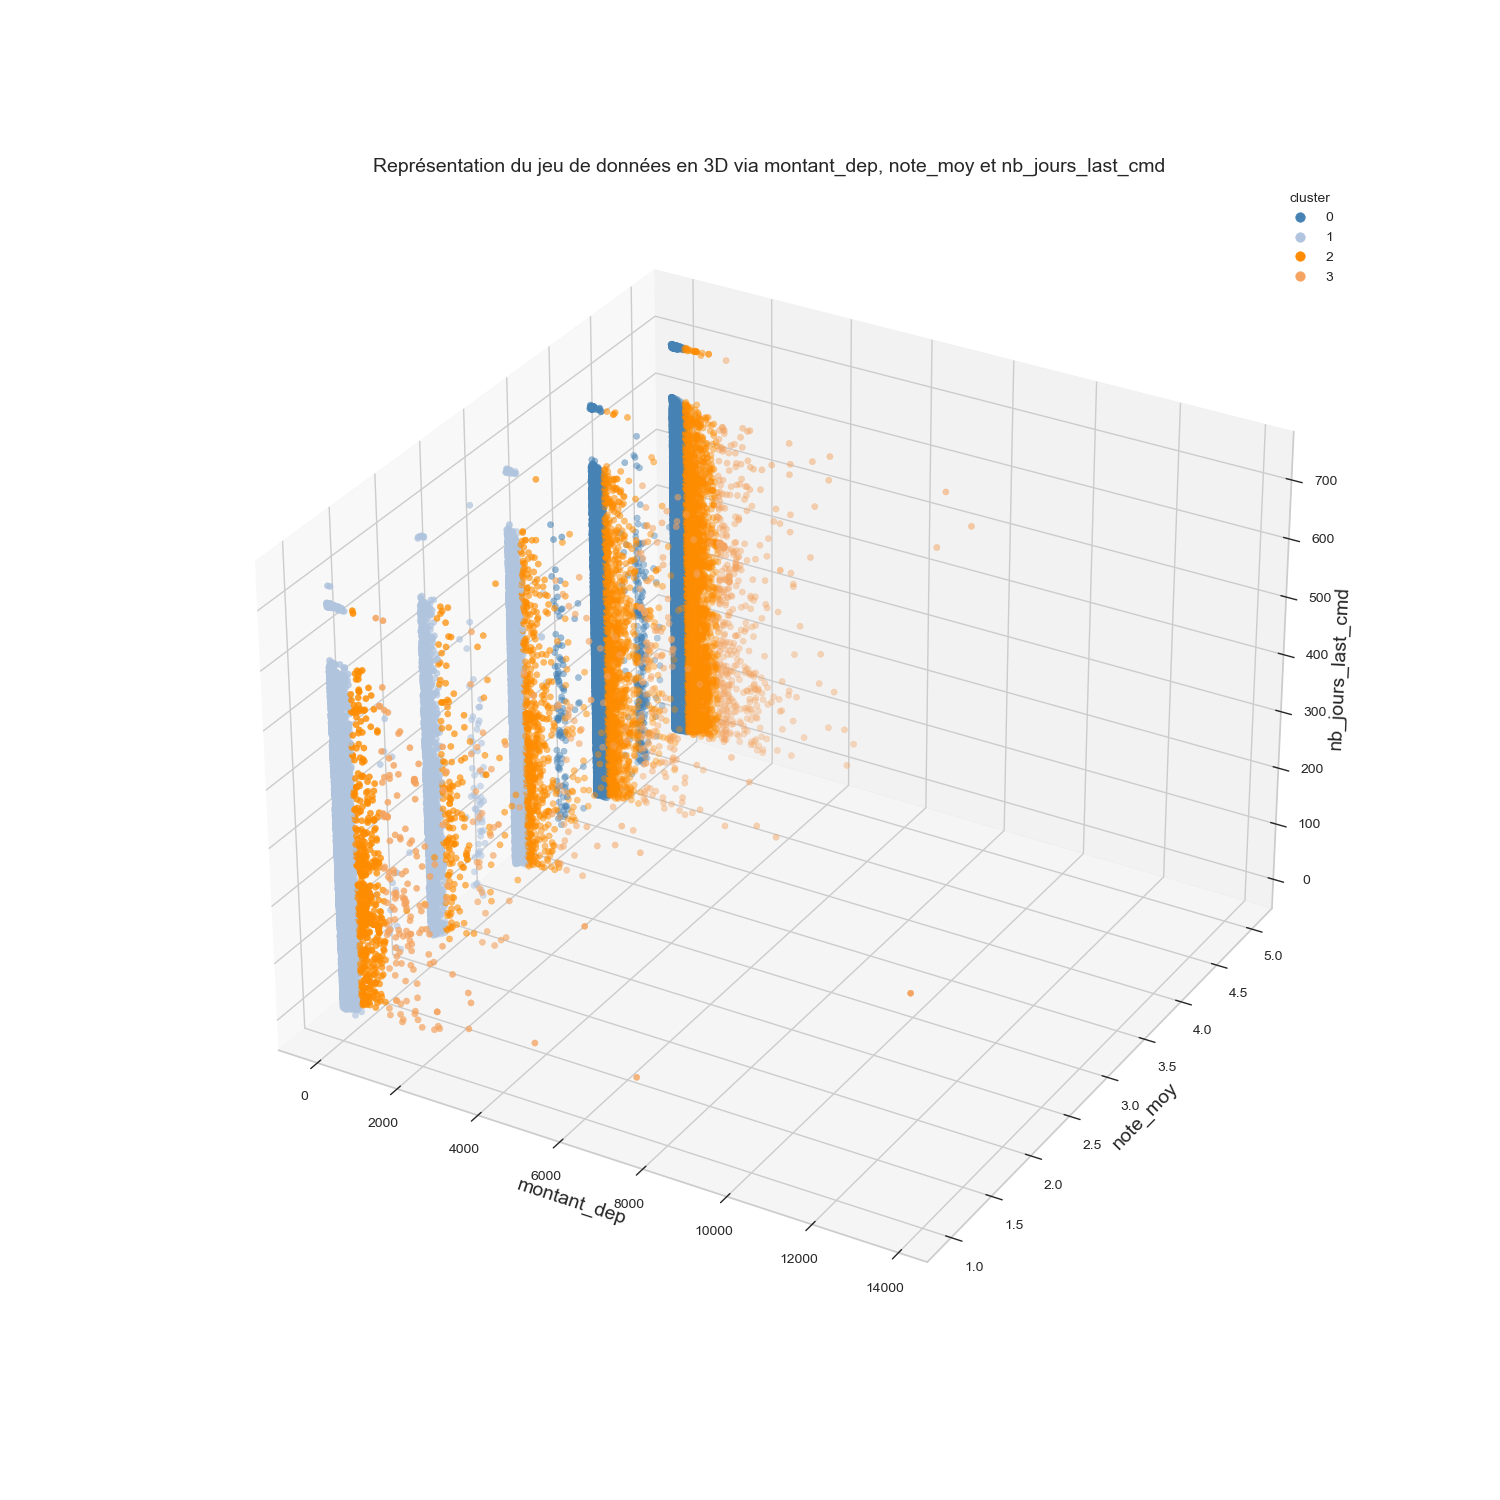

<IPython.core.display.Javascript object>

In [98]:
# Visualisation en 3D des données
plot_3D(
    X_3var,
    "montant_dep, note_moy et nb_jours_last_cmd",
    "montant_dep",
    "note_moy",
    "nb_jours_last_cmd",
    labels=best_kmeans_3var4["label"],
)

In [48]:
# Récupération des centroids
best_model_3var = k_means_3var.iloc[2]
centroids_3var = best_model_3var["centroids"]

# Récupération des coordonnées des centroids dans
# le plan des 3 variables
centroids_3var_inverse = robust_scal_3var.inverse_transform(centroids_3var)

<IPython.core.display.Javascript object>

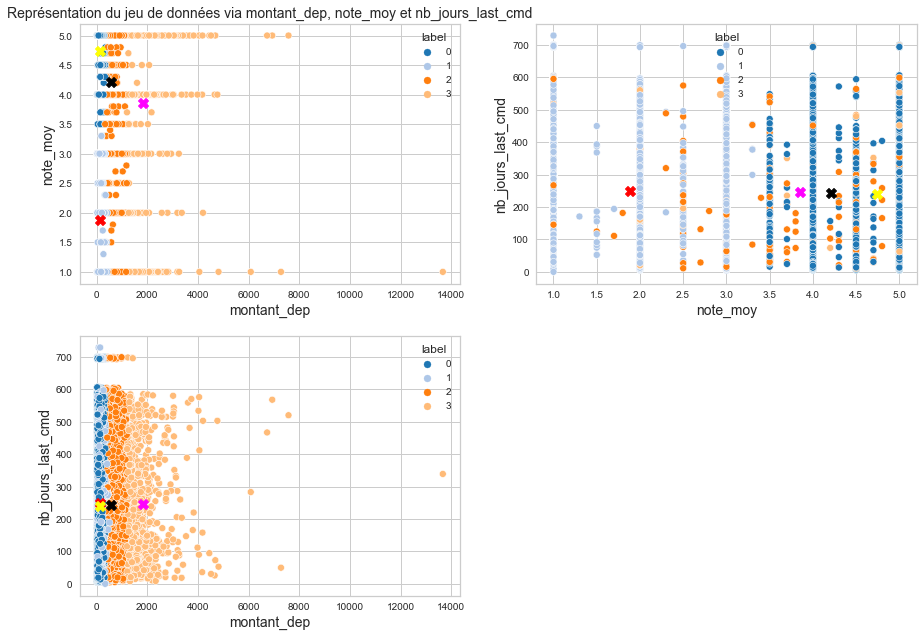

<IPython.core.display.Javascript object>

In [49]:
# Couleur centroids
# l'ordre de la liste ne correspond à l'ordre des clusters
# Assignation des couleurs aux clusters
# 0 = yellow ; 1 = red ; 2 = black ; 3 = magenta
color_list = ["red", "black", "magenta", "yellow"]

# Visualisation des points
plot_3var(
    X_3var,
    "montant_dep, note_moy et nb_jours_last_cmd",
    "montant_dep",
    "note_moy",
    "nb_jours_last_cmd",
    labels=best_kmeans_3var4["label"],
    centroid=centroids_3var_inverse,
)

<IPython.core.display.Javascript object>


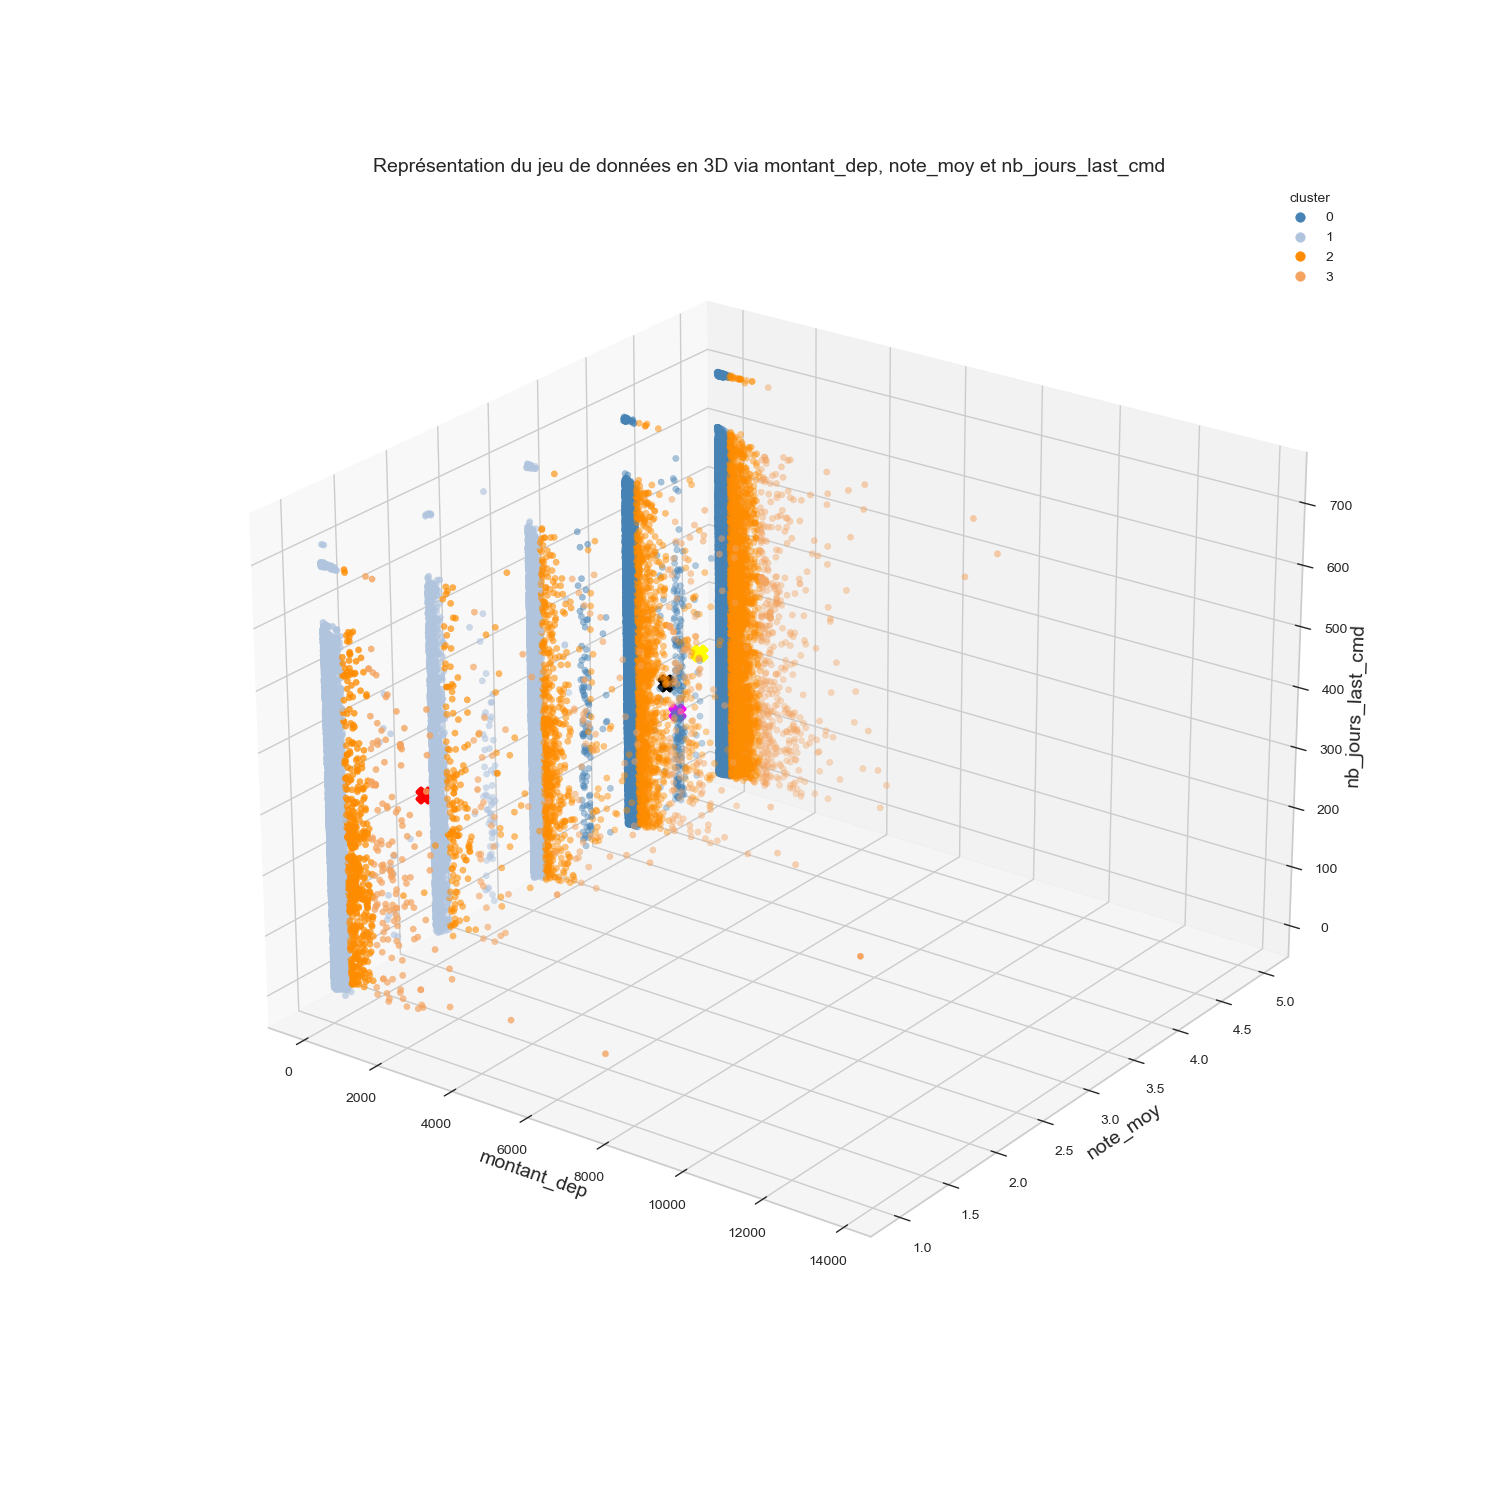

<IPython.core.display.Javascript object>

In [99]:
color_list = ["red", "black", "magenta", "yellow"]
# Visualisation en 3D
plot_3D(
    X_3var,
    "montant_dep, note_moy et nb_jours_last_cmd",
    "montant_dep",
    "note_moy",
    "nb_jours_last_cmd",
    labels=best_kmeans_3var4["label"],
    centroid=centroids_3var_inverse,
)

<IPython.core.display.Javascript object>


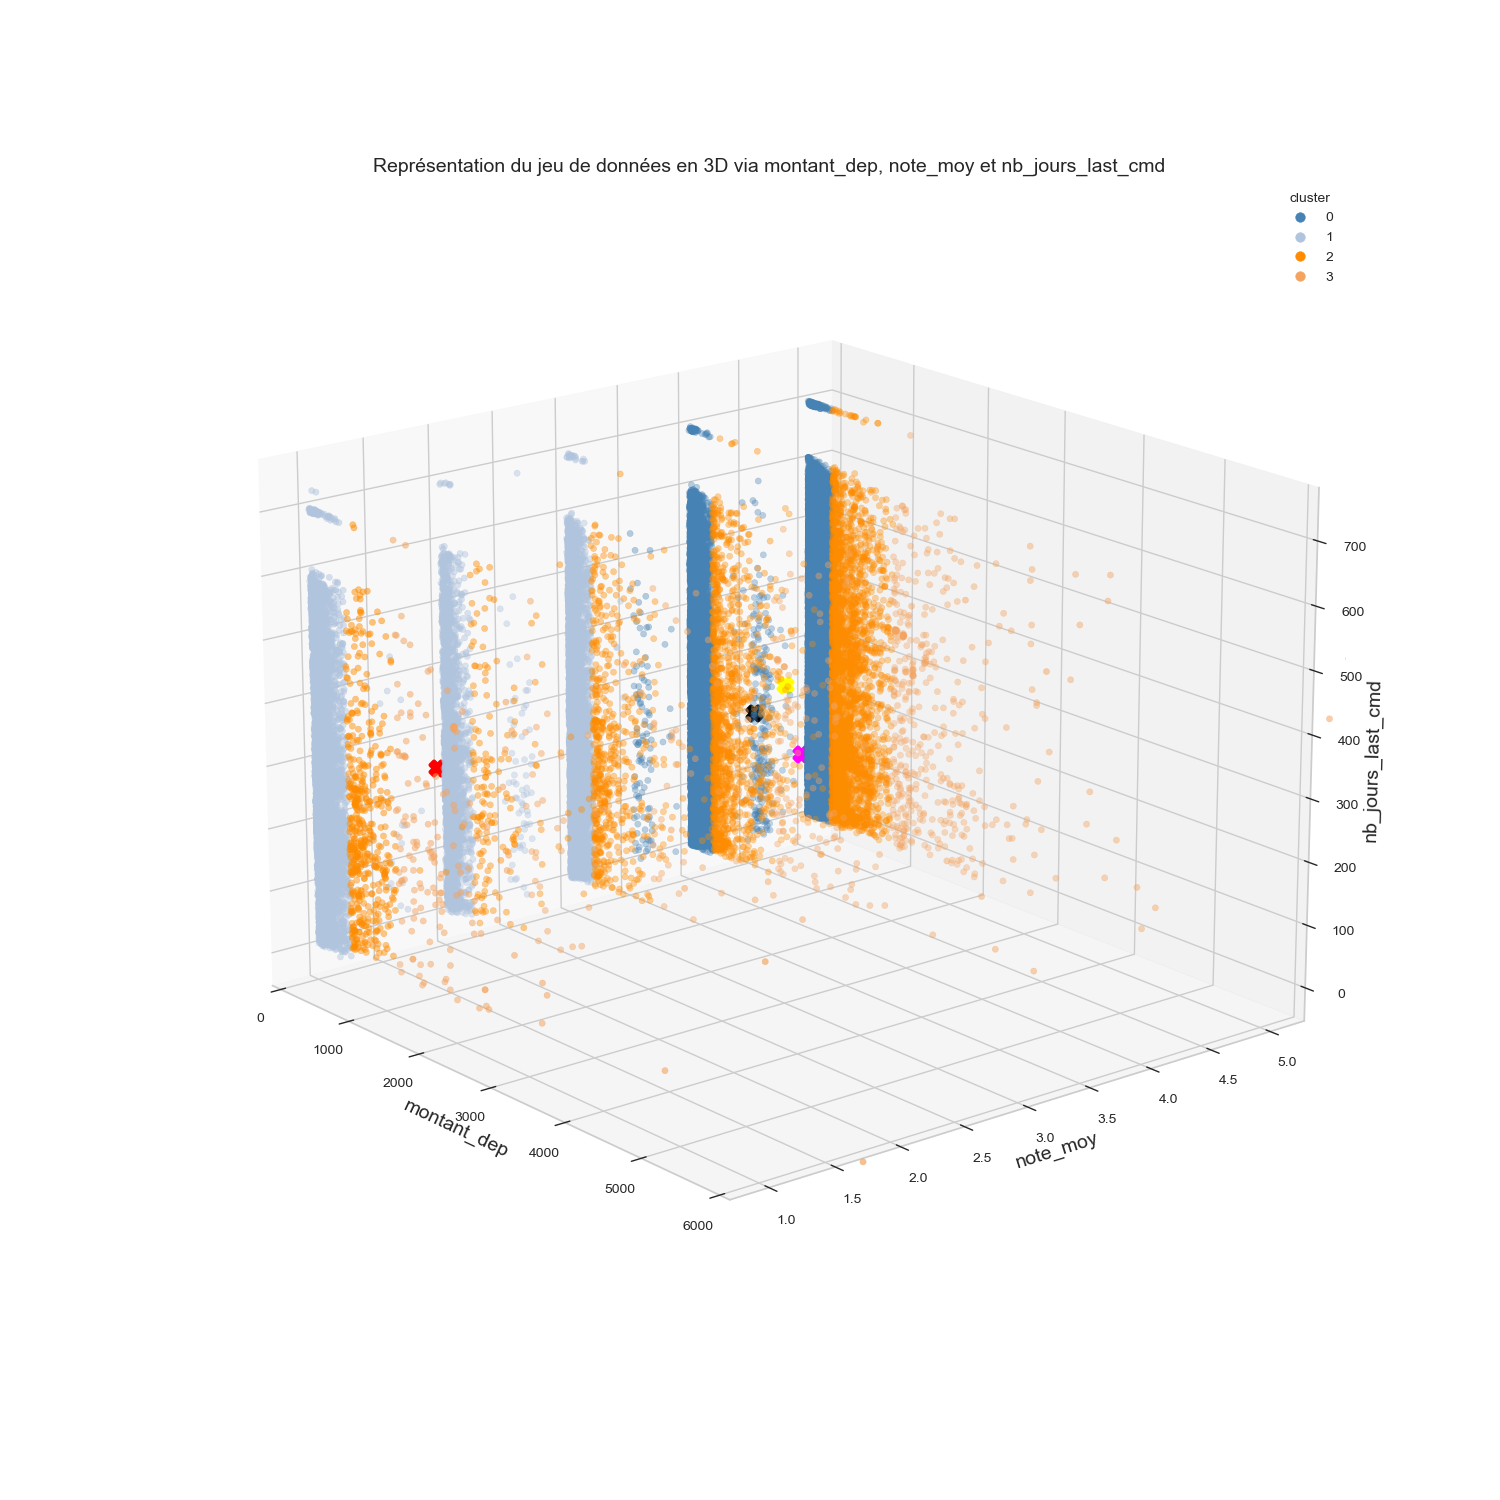

<IPython.core.display.Javascript object>

In [100]:
# Visualisation en 3D en zoomant sur un montant dépensé
# inférieur à 6000
plt.figure(figsize=(15, 15))
ax = plt.axes(projection="3d")
plt.title(
    "Représentation du jeu de données en 3D via montant_dep, note_moy et nb_jours_last_cmd",
    size=14,
)
g = ax.scatter(
    X_3var[:, 0], X_3var[:, 1], X_3var[:, 2], c=best_kmeans_3var4["label"], cmap=newcmp,
)
ax.set_xlabel("montant_dep", size=14)
ax.set_ylabel("note_moy", size=14)
ax.set_zlabel("nb_jours_last_cmd", size=14)
ax.legend(*g.legend_elements(), title="cluster")
ax.set_xlim(0, 6000)


for i in range(len(centroids_3var_inverse)):
    ax.scatter(
        centroids_3var_inverse[i, 0],
        centroids_3var_inverse[i, 1],
        centroids_3var_inverse[i, 2],
        marker="X",
        linewidths=3,
        color=color_list[i],
        s=100,
        zorder=100,
    )
plt.show()

#### b. Comparaison des métriques
On va comparer les résultats entre les 3 modèles de KMeans ci-dessus.

In [50]:
# Dataframe pour regrouper les résultats
results = pd.DataFrame(
    columns=[
        "model",
        "n_clusters",
        "labels",
        "inertia",
        "silhouette_score",
        "davies_bouldin_score",
        "calinski_harabasz_score",
    ]
)

# On ajoute chaque modèle
results = results.append(k_means_all.loc[2, :], ignore_index=True)
results["model"] = results["model"].replace("KMeans(n_clusters=4)", "5 variables")

results = results.append(k_means_pca_all.loc[2, :], ignore_index=True)
results["model"] = results["model"].replace("KMeans(n_clusters=4)", "5 variables - PCA")

results = results.append(k_means_3var.loc[2, :], ignore_index=True)
results["model"] = results["model"].replace("KMeans(n_clusters=4)", "3 variables")
results

model n_clusters  \
0        5 variables          4   
1  5 variables - PCA          4   
2        3 variables          4   

                                              labels        inertia  \
0  [0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, ...  215172.512681   
1  [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...  178014.368635   
2  [3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, ...  176822.297630   

   silhouette_score  davies_bouldin_score  calinski_harabasz_score  \
0          0.493312              0.811262             54707.542312   
1          0.517806              0.733576             66050.119514   
2          0.518691              0.731565             66253.074223   

                                           centroids  
0  [[0.024762611275962965, 0.06264305476747534, 0...  
1  [[-0.13707056385141225, -2.2352422229776403, -...  
2  [[0.20028806062546006, -3.118631063550638, 0.1...

<IPython.core.display.Javascript object>

In [51]:
def plot_result(df, col):

    """ Fonction pour visualiser/comparer les score d'une métrique 
    selon le modèle
        
    - Arguments :
        - df : dataframe avec les résultats
        - col : colonne (=métrique) du dataframe dont on souhaite comparer
        les résultats selon le modèle
    
    - Affiche :
        - 1 graphe de type barplot
    """

    # initialisation de la figure
    plt.figure(figsize=(6, 6))

    # barplot
    ax = sns.barplot(x="model", y=col, data=df)
    plt.ylabel(col, size=14)
    plt.xlabel("Modèle", size=14)
    ax.set_xticklabels(df["model"].unique(), size=14)

    # ajout des étiquettes pour afficher valeurs de la colonne
    for p in ax.patches:
        ax.annotate(
            format((p.get_height()), ".4f"),
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
            fontsize=13,
        )

    plt.show()

<IPython.core.display.Javascript object>

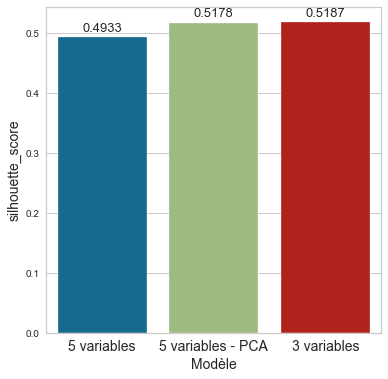

<IPython.core.display.Javascript object>

In [52]:
plot_result(results, "silhouette_score")

Le score le plus élevé (le meilleur) est obtenu pour le modèle avec 3 variables.

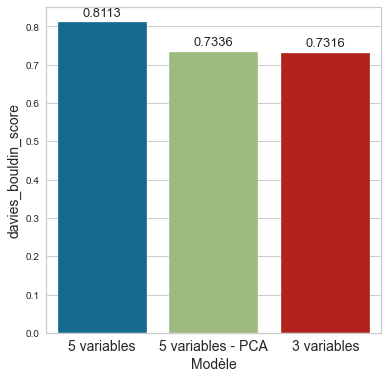

<IPython.core.display.Javascript object>

In [53]:
plot_result(results, "davies_bouldin_score")

Le score le plus faible (le meilleur) est obtenu pour le modèle avec 3 variables.

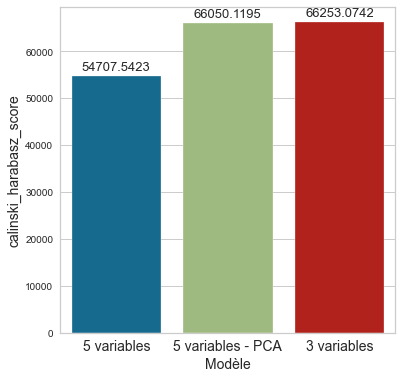

<IPython.core.display.Javascript object>

In [54]:
plot_result(results, "calinski_harabasz_score")

Le score le plus élevé (le meilleur) est obtenu pour le modèle avec 3 variables.

On va donc garder le modèle avec 3 variables.

#### c. Caractérisation des clusters

In [55]:
def plot_var_cluster(X_with_col_label):

    """ Fonction pour visualiser la répartition des variables
    selon les clusters ( = labels)
        
    - Arguments :
        - X_with_col_label : dataframe d'origine avec la colonne label
    
    - Affiche :
        - 2 graphes pour chaque variable du dataframe X_with_col_label
            - barplot représentant la moyenne de la variable selon le cluster
            - boxplot de la variable selon le cluster
    """

    # On regroupe par label
    X_labeled = X_with_col_label.groupby("label").mean()

    for col in X_labeled.columns:

        # Initialisation de la figure
        f, axes = plt.subplots(1, 2, figsize=(15, 4))

        # boxplot de la variable selon le cluster
        sns.boxplot(
            y="label",
            x=col,
            data=X_with_col_label,
            orient="h",
            ax=axes[0],
            palette="tab20",
        )

        # barplot de la valeur moyenne de la variable selon le cluster
        sns.barplot(
            y=X_labeled.index,
            x=col,
            data=X_labeled,
            orient="h",
            ax=axes[1],
            palette="tab20",
        )

        plt.title("Moyenne de {} pour chaque cluster".format(col), size=14)
        plt.show()

<IPython.core.display.Javascript object>

##### Sur toutes les données

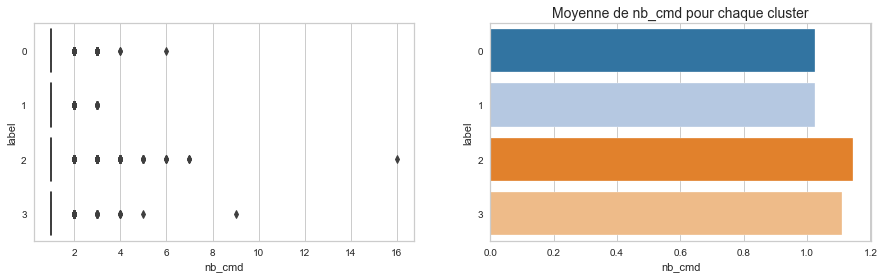

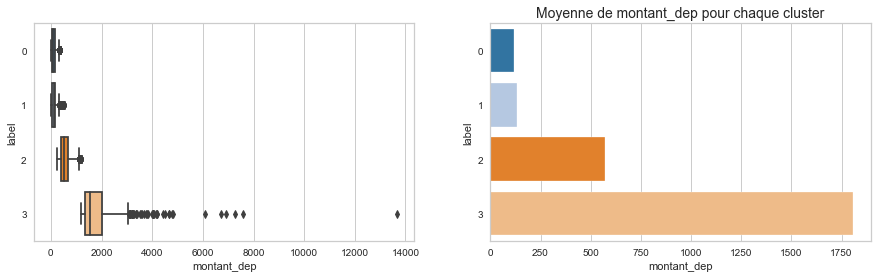

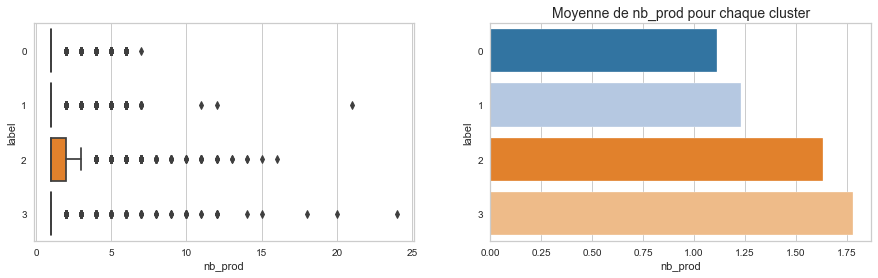

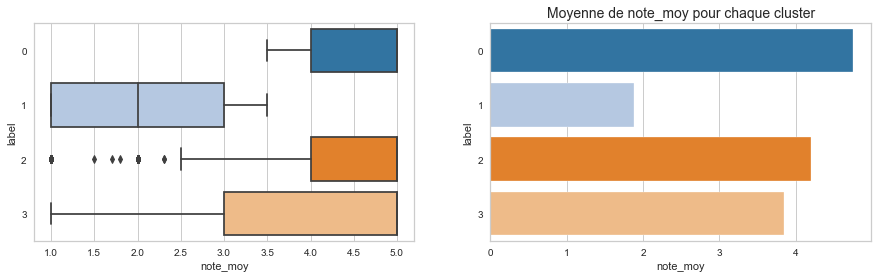

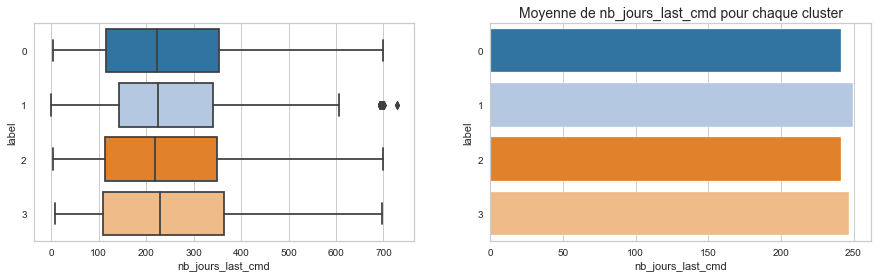

<IPython.core.display.Javascript object>

In [56]:
# 5 variables
plot_var_cluster(best_kmeans_all4)

- Le groupe 0 (le plus nombreux) est parmi ceux qui dépensent le moins et celui qui met les meilleures notes.
- Le groupe 1 est parmi ceux qui dépensent le moins et celui qui met le plus de mauvaises notes.
- Le groupe 2 est celui qui dépense moyennement et qui met de bonnes notes.
- Le groupe 3 est celui qui dépense le plus

On va regarder les variables au sein de chaque cluster.

In [57]:
best_kmeans_all4.loc[best_kmeans_all4["label"] == 0].describe()

nb_cmd   montant_dep       nb_prod      note_moy  \
count  67411.000000  67411.000000  67411.000000  67411.000000   
mean       1.024803    115.392880      1.112341      4.746651   
std        0.163976     72.414645      0.403152      0.435120   
min        1.000000      9.590000      1.000000      3.500000   
25%        1.000000     58.640000      1.000000      4.000000   
50%        1.000000     97.620000      1.000000      5.000000   
75%        1.000000    156.090000      1.000000      5.000000   
max        6.000000    358.500000      7.000000      5.000000   

       nb_jours_last_cmd    label  
count       67411.000000  67411.0  
mean          241.372623      0.0  
std           154.366359      0.0  
min             4.754398      0.0  
25%           115.450804      0.0  
50%           223.735972      0.0  
75%           354.643900      0.0  
max           699.673692      0.0

<IPython.core.display.Javascript object>

In [58]:
best_kmeans_all4.loc[best_kmeans_all4["label"] == 1].describe()

nb_cmd   montant_dep       nb_prod      note_moy  \
count  19766.000000  19766.000000  19766.000000  19766.000000   
mean       1.023475    131.226898      1.228372      1.880907   
std        0.155367     89.816518      0.620549      0.917581   
min        1.000000     10.890000      1.000000      1.000000   
25%        1.000000     63.822500      1.000000      1.000000   
50%        1.000000    106.980000      1.000000      2.000000   
75%        1.000000    173.815000      1.000000      3.000000   
max        3.000000    511.180000     21.000000      3.500000   

       nb_jours_last_cmd    label  
count       19766.000000  19766.0  
mean          249.375704      1.0  
std           147.696308      0.0  
min             0.000000      1.0  
25%           142.499774      1.0  
50%           224.525266      1.0  
75%           340.928903      1.0  
max           728.494190      1.0

<IPython.core.display.Javascript object>

In [59]:
best_kmeans_all4.loc[best_kmeans_all4["label"] == 2].describe()

nb_cmd  montant_dep      nb_prod     note_moy  nb_jours_last_cmd  \
count  6718.000000  6718.000000  6718.000000  6718.000000        6718.000000   
mean      1.144091   571.217401     1.633373     4.201742         241.265309   
std       0.491179   203.734042     1.305387     1.206453         155.438845   
min       1.000000   242.190000     1.000000     1.000000           4.783727   
25%       1.000000   405.352500     1.000000     4.000000         113.587786   
50%       1.000000   515.150000     1.000000     5.000000         218.557431   
75%       1.000000   685.700000     2.000000     5.000000         349.444832   
max      16.000000  1192.480000    16.000000     5.000000         698.806817   

        label  
count  6718.0  
mean      2.0  
std       0.0  
min       2.0  
25%       2.0  
50%       2.0  
75%       2.0  
max       2.0

<IPython.core.display.Javascript object>

In [60]:
best_kmeans_all4.loc[best_kmeans_all4["label"] == 3].describe()

nb_cmd   montant_dep     nb_prod    note_moy  nb_jours_last_cmd  \
count  825.000000    825.000000  825.000000  825.000000         825.000000   
mean     1.111515   1805.676788    1.779394    3.851636         246.736901   
std      0.484894    836.013130    2.174948    1.552183         160.475212   
min      1.000000   1172.670000    1.000000    1.000000           8.061331   
25%      1.000000   1338.410000    1.000000    3.000000         109.866227   
50%      1.000000   1562.570000    1.000000    5.000000         229.533877   
75%      1.000000   2023.580000    1.000000    5.000000         364.934595   
max      9.000000  13664.080000   24.000000    5.000000         697.785058   

       label  
count  825.0  
mean     3.0  
std      0.0  
min      3.0  
25%      3.0  
50%      3.0  
75%      3.0  
max      3.0

<IPython.core.display.Javascript object>

##### Sur toutes les données avec les 5 variables projetées sur 3 axes PCA

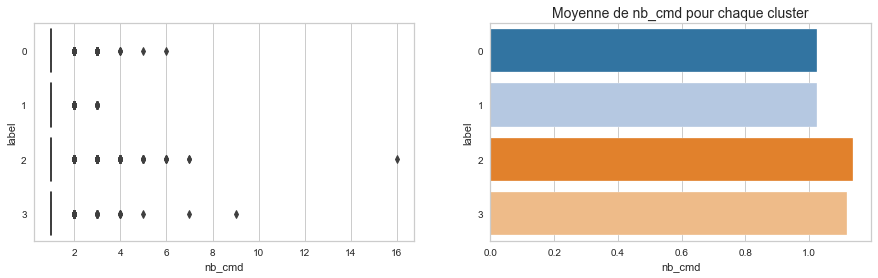

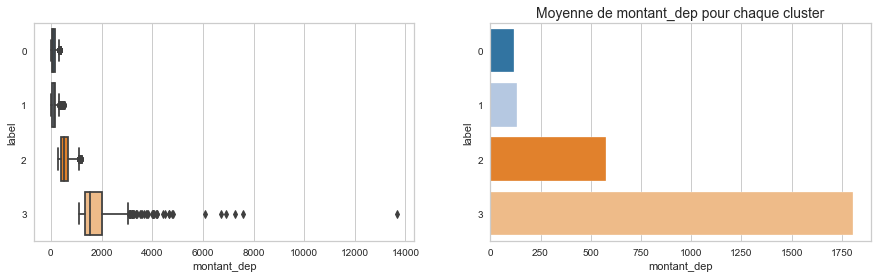

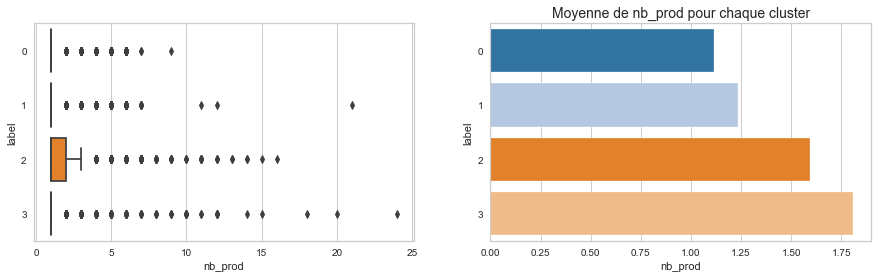

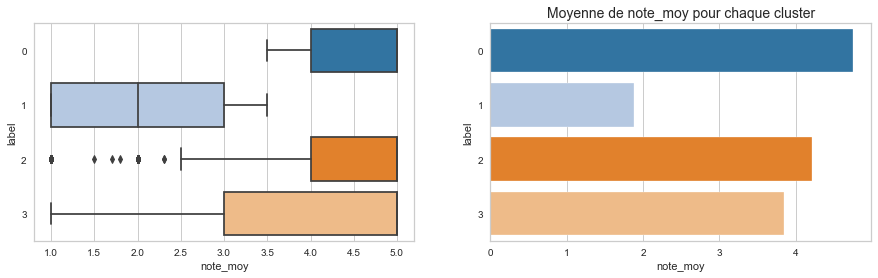

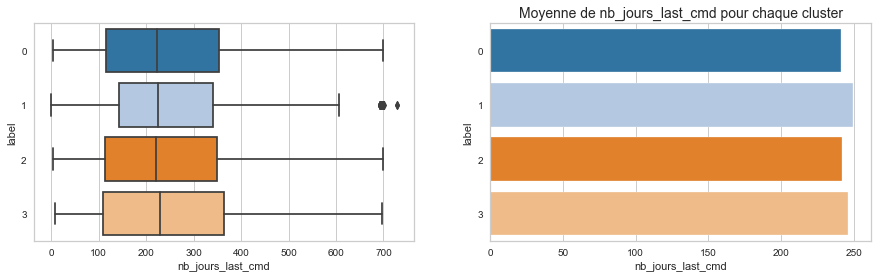

<IPython.core.display.Javascript object>

In [61]:
# 5 variables PCA
plot_var_cluster(best_kmeans_pca_all4)

Même répartion que précédemment

On va regarder les variables au sein de chaque cluster.

In [62]:
best_kmeans_pca_all4.loc[best_kmeans_pca_all4["label"] == 0].describe()

nb_cmd   montant_dep       nb_prod      note_moy  \
count  67448.000000  67448.000000  67448.000000  67448.000000   
mean       1.025323    115.485300      1.114889      4.746571   
std        0.166454     72.497836      0.413688      0.435154   
min        1.000000      9.590000      1.000000      3.500000   
25%        1.000000     58.690000      1.000000      4.000000   
50%        1.000000     97.660000      1.000000      5.000000   
75%        1.000000    156.240000      1.000000      5.000000   
max        6.000000    357.130000      9.000000      5.000000   

       nb_jours_last_cmd    label  
count       67448.000000  67448.0  
mean          241.326911      0.0  
std           154.375309      0.0  
min             4.754398      0.0  
25%           115.426832      0.0  
50%           223.700052      0.0  
75%           354.613105      0.0  
max           699.673692      0.0

<IPython.core.display.Javascript object>

In [63]:
best_kmeans_pca_all4.loc[best_kmeans_pca_all4["label"] == 1].describe()

nb_cmd   montant_dep       nb_prod      note_moy  \
count  19798.000000  19798.000000  19798.000000  19798.000000   
mean       1.024346    131.604195      1.233609      1.881796   
std        0.158328     90.265232      0.634519      0.917876   
min        1.000000     10.890000      1.000000      1.000000   
25%        1.000000     63.882500      1.000000      1.000000   
50%        1.000000    107.080000      1.000000      2.000000   
75%        1.000000    174.152500      1.000000      3.000000   
max        3.000000    507.680000     21.000000      3.500000   

       nb_jours_last_cmd    label  
count       19798.000000  19798.0  
mean          249.314317      1.0  
std           147.663996      0.0  
min             0.000000      1.0  
25%           142.492465      1.0  
50%           224.490434      1.0  
75%           340.870336      1.0  
max           728.494190      1.0

<IPython.core.display.Javascript object>

In [64]:
best_kmeans_pca_all4.loc[best_kmeans_pca_all4["label"] == 2].describe()

nb_cmd  montant_dep      nb_prod     note_moy  nb_jours_last_cmd  \
count  6647.000000  6647.000000  6647.000000  6647.000000        6647.000000   
mean      1.136603   573.645566     1.593350     4.208711         241.917863   
std       0.478544   202.923240     1.259799     1.203265         155.485204   
min       1.000000   298.790000     1.000000     1.000000           4.783727   
25%       1.000000   407.625000     1.000000     4.000000         113.891979   
50%       1.000000   517.240000     1.000000     5.000000         219.982130   
75%       1.000000   688.245000     2.000000     5.000000         349.746603   
max      16.000000  1198.890000    16.000000     5.000000         698.806817   

        label  
count  6647.0  
mean      2.0  
std       0.0  
min       2.0  
25%       2.0  
50%       2.0  
75%       2.0  
max       2.0

<IPython.core.display.Javascript object>

In [65]:
best_kmeans_pca_all4.loc[best_kmeans_pca_all4["label"] == 3].describe()

nb_cmd   montant_dep     nb_prod    note_moy  nb_jours_last_cmd  \
count  827.000000    827.000000  827.000000  827.000000         827.000000   
mean     1.118501   1804.023833    1.806530    3.847158         246.357905   
std      0.525830    835.673674    2.222231    1.553751         160.510924   
min      1.000000   1122.720000    1.000000    1.000000           8.061331   
25%      1.000000   1338.410000    1.000000    3.000000         109.770498   
50%      1.000000   1556.700000    1.000000    5.000000         229.527315   
75%      1.000000   2023.290000    1.000000    5.000000         364.872801   
max      9.000000  13664.080000   24.000000    5.000000         697.785058   

       label  
count  827.0  
mean     3.0  
std      0.0  
min      3.0  
25%      3.0  
50%      3.0  
75%      3.0  
max      3.0

<IPython.core.display.Javascript object>

##### Sur toutes les données avec les 3 variables : montant_dep, note_moy et nb_jours_last_cmd

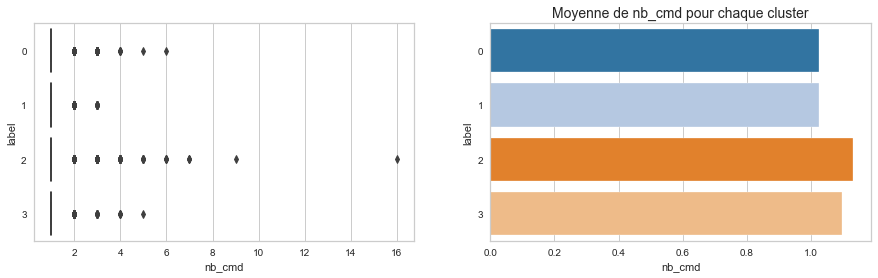

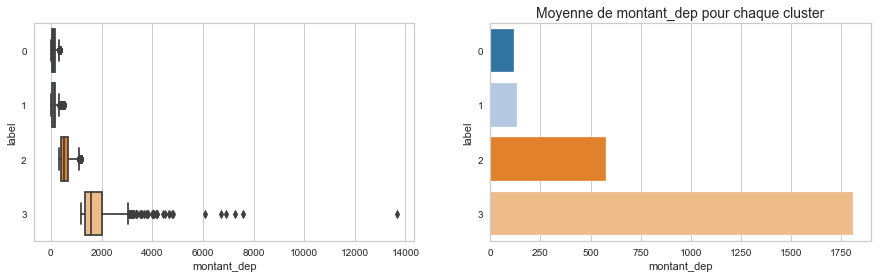

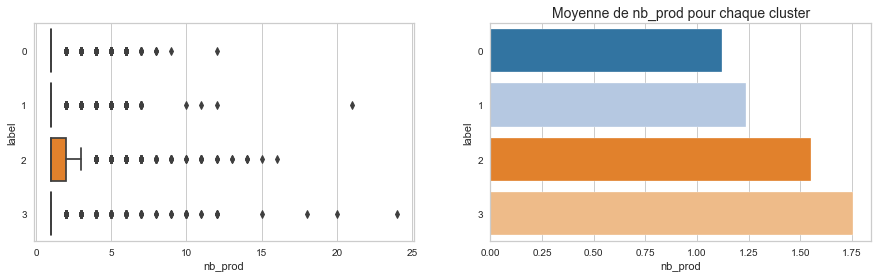

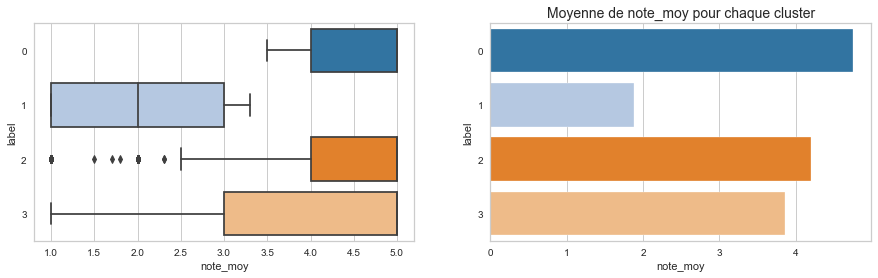

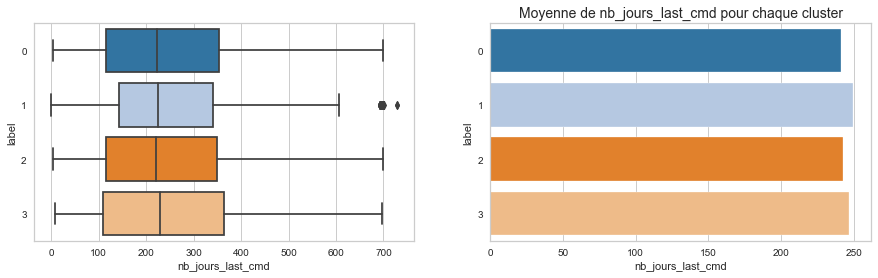

<IPython.core.display.Javascript object>

In [66]:
# 3 variables
plot_var_cluster(best_kmeans_3var4)

Même répartition que précédemment

On va regarder les variables au sein de chaque cluster.

In [67]:
df_label_0 = best_kmeans_3var4.loc[best_kmeans_3var4["label"] == 0]
df_label_0.describe()

nb_cmd   montant_dep       nb_prod      note_moy  \
count  67590.000000  67590.000000  67590.000000  67590.000000   
mean       1.026424    115.945937      1.120195      4.746307   
std        0.170846     73.120459      0.435408      0.435417   
min        1.000000      9.590000      1.000000      3.500000   
25%        1.000000     58.752500      1.000000      4.000000   
50%        1.000000     97.790000      1.000000      5.000000   
75%        1.000000    156.747500      1.000000      5.000000   
max        6.000000    356.160000     12.000000      5.000000   

       nb_jours_last_cmd    label  
count       67590.000000  67590.0  
mean          241.252961      0.0  
std           154.368447      0.0  
min             4.754398      0.0  
25%           115.293530      0.0  
50%           223.629248      0.0  
75%           354.553131      0.0  
max           699.673692      0.0

<IPython.core.display.Javascript object>

In [68]:
# Pourcentage de cliens du cluster 0 ayant fait plus de 1 commande
df_label_0["nb_cmd"].loc[df_label_0["nb_cmd"] > 1].count() / len(df_label_0)

0.024900133155792276

<IPython.core.display.Javascript object>

In [69]:
# Pourcentage de cliens du cluster 0 commandant plus de 1 produit
df_label_0["nb_prod"].loc[df_label_0["nb_prod"] > 1].count() / len(df_label_0)

0.09351975144252109

<IPython.core.display.Javascript object>

In [70]:
df_label_1 = best_kmeans_3var4.loc[best_kmeans_3var4["label"] == 1]
df_label_1.describe()

nb_cmd   montant_dep       nb_prod      note_moy  \
count  19813.000000  19813.000000  19813.000000  19813.000000   
mean       1.024176    131.869379      1.235149      1.881482   
std        0.157813     90.720152      0.639465      0.917675   
min        1.000000     10.890000      1.000000      1.000000   
25%        1.000000     63.960000      1.000000      1.000000   
50%        1.000000    107.110000      1.000000      2.000000   
75%        1.000000    174.410000      1.000000      3.000000   
max        3.000000    507.980000     21.000000      3.300000   

       nb_jours_last_cmd    label  
count       19813.000000  19813.0  
mean          249.336099      1.0  
std           147.643976      0.0  
min             0.000000      1.0  
25%           142.512535      1.0  
50%           224.527396      1.0  
75%           340.929954      1.0  
max           728.494190      1.0

<IPython.core.display.Javascript object>

In [71]:
# Pourcentage de cliens du cluster 1 ayant fait plus de 1 commande
df_label_1["nb_cmd"].loc[df_label_1["nb_cmd"] > 1].count() / len(df_label_1)

0.02351991116943421

<IPython.core.display.Javascript object>

In [72]:
# Pourcentage de cliens du cluster 1 commandant plus de 1 produit
df_label_1["nb_prod"].loc[df_label_1["nb_prod"] > 1].count() / len(df_label_1)

0.171049311058396

<IPython.core.display.Javascript object>

In [73]:
df_label_2 = best_kmeans_3var4.loc[best_kmeans_3var4["label"] == 2]
df_label_2.describe()

nb_cmd  montant_dep      nb_prod     note_moy  nb_jours_last_cmd  \
count  6496.000000  6496.000000  6496.000000  6496.000000        6496.000000   
mean      1.130850   579.623922     1.551570     4.204880         242.547787   
std       0.485792   202.871000     1.231779     1.206876         155.611448   
min       1.000000   332.340000     1.000000     1.000000           4.783727   
25%       1.000000   412.420000     1.000000     4.000000         114.964803   
50%       1.000000   521.550000     1.000000     5.000000         220.475341   
75%       1.000000   695.250000     2.000000     5.000000         350.377885   
max      16.000000  1192.480000    16.000000     5.000000         698.806817   

        label  
count  6496.0  
mean      2.0  
std       0.0  
min       2.0  
25%       2.0  
50%       2.0  
75%       2.0  
max       2.0

<IPython.core.display.Javascript object>

In [74]:
# Pourcentage de cliens du cluster 2 ayant fait plus de 1 commande
df_label_2["nb_cmd"].loc[df_label_2["nb_cmd"] > 1].count() / len(df_label_2)

0.10160098522167488

<IPython.core.display.Javascript object>

In [75]:
# Pourcentage de cliens du cluster 2 commandant plus de 1 produit
df_label_2["nb_prod"].loc[df_label_2["nb_prod"] > 1].count() / len(df_label_2)

0.28048029556650245

<IPython.core.display.Javascript object>

In [76]:
df_label_3 = best_kmeans_3var4.loc[best_kmeans_3var4["label"] == 3]
df_label_3.describe()

nb_cmd   montant_dep     nb_prod    note_moy  nb_jours_last_cmd  \
count  821.000000    821.000000  821.000000  821.000000         821.000000   
mean     1.098660   1808.710475    1.753959    3.853593         246.935650   
std      0.396645    836.914946    2.125427    1.554247         160.809499   
min      1.000000   1191.480000    1.000000    1.000000           8.061331   
25%      1.000000   1338.510000    1.000000    3.000000         109.834259   
50%      1.000000   1568.720000    1.000000    5.000000         229.954410   
75%      1.000000   2023.580000    1.000000    5.000000         364.981319   
max      5.000000  13664.080000   24.000000    5.000000         697.785058   

       label  
count  821.0  
mean     3.0  
std      0.0  
min      3.0  
25%      3.0  
50%      3.0  
75%      3.0  
max      3.0

<IPython.core.display.Javascript object>

In [77]:
# Pourcentage de cliens du cluster 3 ayant fait plus de 1 commande
df_label_3["nb_cmd"].loc[df_label_3["nb_cmd"] > 1].count() / len(df_label_3)

0.0730816077953715

<IPython.core.display.Javascript object>

In [78]:
# Pourcentage de cliens du cluster 3 commandant plus de 1 produit
df_label_3["nb_prod"].loc[df_label_3["nb_prod"] > 1].count() / len(df_label_3)

0.23751522533495736

<IPython.core.display.Javascript object>

### 3.3. DBSCAN

On va tester le DBSCAN (Density-Based Spatial Clustering of Application with Noise).

In [79]:
def result_DBSCAN(eps_range, min_samples_value, X, model):

    """ Fonction pour tester différentes valeurs de eps pour le DBSCAN
    - pour chaque valeur de eps 
        - fit le modèle
        - récupère les clusters label
        - récupère les valeurs pour les scores
            - inertie
            - coefficient de silhouette
            - indice de davies_bouldin
            - calinski_harabasz_score
    - Arguments :
        - eps_range : liste des valeurs à tester
        - min_samples_value : number of samples in a neighborhood for 
                                    a point to be considered as a core point (default = 5)
        - X : data à fitter
        - model : str pour distinguer selon le nombre de variables
    
    - Retourne :
        - un dataframe avec les résultats
    """

    # Création du dataframe
    results = pd.DataFrame(
        columns=[
            "model",
            "eps",
            "min_samples",
            "n_clusters",
            "labels",
            "silhouette_score",
            "davies_bouldin_score",
            "calinski_harabasz_score",
        ]
    )

    # On boucle sur le nombre de clusters
    for eps_value in eps_range:

        # initialisation aléatoire et unique
        cls = DBSCAN(
            eps=eps_value,
            # maximum distance between two samples for one
            # to be considered as in the neighborhood of the other
            # default 0.5
            min_samples=min_samples_value,
        ).fit(X_scaled)
        # number of samples in a neighborhood for a point to be considered as a core point
        # default 5

        # on fit le modèle
        cls.fit(X)

        # prédiction des étiquettes
        labels = cls.labels_

        # nombre de clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Récupération des résultats
        result = {
            "model": model,
            "eps": eps_value,
            "min_samples": min_samples_value,
            "n_clusters": n_clusters,
            "labels": labels,
            "silhouette_score": silhouette_score(X, labels),
            "davies_bouldin_score": davies_bouldin_score(X, labels),
            "calinski_harabasz_score": calinski_harabasz_score(X, labels),
        }

        # On compile dans le dataframe
        results = results.append(result, ignore_index=True)

    return results

<IPython.core.display.Javascript object>

In [80]:
# Pour des raisons de performance, on ne peut pas tester en même
# temps beaucoup de valeurs pour les hyperparamètres

# 5 variables
eps_range = [0.5]  # valeur par défaut
min_samples_value = 5  # valeur par défaut
DBSCAN5_all = result_DBSCAN(eps_range, min_samples_value, X_scaled_all, "5 variables")
DBSCAN5_all

model  eps min_samples n_clusters  \
0  5 variables  0.5           5         79   

                                              labels  silhouette_score  \
0  [0, 1, 2, 1, 0, 1, 1, 3, 1, 4, 2, 0, 0, 1, 1, ...          0.144325   

   davies_bouldin_score  calinski_harabasz_score  
0              1.752868              1108.774836

<IPython.core.display.Javascript object>

In [81]:
# 5 variables sur PCA
DBSCAN5_pca_all = result_DBSCAN(
    eps_range, min_samples_value, X_pca_all, "5 variables - PCA"
)
DBSCAN5_pca_all

model  eps min_samples n_clusters  \
0  5 variables - PCA  0.5           5         14   

                                              labels  silhouette_score  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0.577294   

   davies_bouldin_score  calinski_harabasz_score  
0              2.236152              1576.426062

<IPython.core.display.Javascript object>

In [82]:
# 3 variables
DBSCAN5_3var = result_DBSCAN(eps_range, min_samples_value, X_scaled_3var, "3 variables")
DBSCAN5_3var

model  eps min_samples n_clusters  \
0  3 variables  0.5           5         18   

                                              labels  silhouette_score  \
0  [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...          0.439375   

   davies_bouldin_score  calinski_harabasz_score  
0              2.789958              3691.033668

<IPython.core.display.Javascript object>

On a trop de clusters, plus d'une douzaine, cela ne sera pas exploitable.

In [83]:
# 5 variables
eps_range = [0.5]
min_samples_value = 10
DBSCAN10_all = result_DBSCAN(eps_range, min_samples_value, X_scaled_all, "5 variables")
DBSCAN10_all

model  eps min_samples n_clusters  \
0  5 variables  0.5          10         45   

                                              labels  silhouette_score  \
0  [0, 1, 2, 1, 0, 1, 1, 3, 1, 4, 2, 0, 0, 1, 1, ...          0.143268   

   davies_bouldin_score  calinski_harabasz_score  
0              1.735412               1967.46407

<IPython.core.display.Javascript object>

In [84]:
# 5 variables sur PCA
DBSCAN10_pca_all = result_DBSCAN(
    eps_range, min_samples_value, X_pca_all, "5 variables - PCA"
)
DBSCAN10_pca_all

model  eps min_samples n_clusters  \
0  5 variables - PCA  0.5          10          9   

                                              labels  silhouette_score  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0.652092   

   davies_bouldin_score  calinski_harabasz_score  
0              2.014224              3162.316322

<IPython.core.display.Javascript object>

In [85]:
# Répartition des clusters
best_DBSCAN10_pca_all = df_with_col_label(DBSCAN10_pca_all, 0, X_all)
best_DBSCAN10_pca_all["label"].value_counts()

 0    94113
-1      465
 1       60
 5       14
 7       13
 2       13
 6       12
 3       12
 4       11
 8        7
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Les clusters sont beaucoup trop déséquilibrés.

In [86]:
# 3 variables
DBSCAN10_3var = result_DBSCAN(
    eps_range, min_samples_value, X_scaled_3var, "3 variables"
)
DBSCAN10_3var

model  eps min_samples n_clusters  \
0  3 variables  0.5          10          9   

                                              labels  silhouette_score  \
0  [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...          0.495404   

   davies_bouldin_score  calinski_harabasz_score  
0               1.97453              8628.591499

<IPython.core.display.Javascript object>

In [87]:
# Répartition des clusters
best_DBSCAN10_3var = df_with_col_label(DBSCAN10_3var, 0, X_all)
best_DBSCAN10_3var["label"].value_counts()

 0    80933
 1    13142
-1      499
 2       59
 3       27
 4       19
 6       13
 7       11
 5       10
 8        7
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Il y a trop de clusters, beaucoup de trop petite taille. Par ailleurs, pas mal de clients ne sont affectés à aucun cluster.

In [88]:
# 5 variables
eps_range = [1]
min_samples_value = 5
DBSCAN5_all_1 = result_DBSCAN(eps_range, min_samples_value, X_scaled_all, "5 variables")
DBSCAN5_all_1

model eps min_samples n_clusters  \
0  5 variables   1           5         48   

                                              labels  silhouette_score  \
0  [0, 1, 2, 1, 0, 1, 1, 3, 1, 4, 2, 0, 0, 1, 1, ...          0.164022   

   davies_bouldin_score  calinski_harabasz_score  
0              2.101655              1686.770814

<IPython.core.display.Javascript object>

In [89]:
# 5 variables sur PCA
DBSCAN5_pca_all_1 = result_DBSCAN(
    eps_range, min_samples_value, X_pca_all, "5 variables - PCA"
)
DBSCAN5_pca_all_1

model eps min_samples n_clusters  \
0  5 variables - PCA   1           5          4   

                                              labels  silhouette_score  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0.879351   

   davies_bouldin_score  calinski_harabasz_score  
0               1.71783              3433.607518

<IPython.core.display.Javascript object>

In [90]:
# Répartition des clusters
best_DBSCAN5_pca_all_1 = df_with_col_label(DBSCAN5_pca_all_1, 0, X_all)
best_DBSCAN5_pca_all_1["label"].value_counts()

 0    94622
-1       66
 2       14
 1       11
 3        7
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Il n'y a que 4 clusters, par contre ils sont vraiment trop déséquilibrés...

In [91]:
# 3 variables
DBSCAN5_3var_1 = result_DBSCAN(
    eps_range, min_samples_value, X_scaled_3var, "3 variables"
)
DBSCAN5_3var_1

model eps min_samples n_clusters  \
0  3 variables   1           5          5   

                                              labels  silhouette_score  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          0.796441   

   davies_bouldin_score  calinski_harabasz_score  
0              1.565346              2846.902103

<IPython.core.display.Javascript object>

In [92]:
# Répartition des clusters
best_DBSCAN5_3var_1 = df_with_col_label(DBSCAN5_3var_1, 0, X_all)
best_DBSCAN5_3var_1["label"].value_counts()

 0    94615
-1       69
 3       14
 2       10
 4        7
 1        5
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Là aussi, les clusters sont complètement déséquilibrés.

### 3.4. AgglomerativeClustering
Pour des raisons de performance, impossible de faire tourner ce modèle de machine learning (perte de connexion avec le noyau, plantage de l'ordinateur) sur l'ensemble des données, ce qui permet d'éliminer ce modèle.

In [ ]:
# 5 variables
agglo_clus = AgglomerativeClustering(n_clusters = 4).fit(X_scaled_all)
                                    # default = 2